In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
%matplotlib widget


# Where to get data

http://www.kampff-lab.org/validating-electrodes  
https://web.archive.org/web/20220130061955/http://www.kampff-lab.org/validating-electrodes


In [2]:
cd 2015_09_03_Pair_9_0/

/Users/mike/src/2022_neurotech_course/5 - Spike Sorting/2015_09_03_Pair_9_0


# Load probe coordinates

In [3]:
# fill 17 for absent channel

df_coords = pd.read_csv('Neuroseeker probe - Sheet1.csv', header=None)\
              .fillna(17)\
              .astype(int)+1
df_coords

0    1    2    3
0    21   17   24   18
1    23   20   26   19
2    25   22   28   16
3    27   15   30   14
4    29   13   32   12
5    31   11   34   10
6    33    9   36    8
7    35    7   38    6
8    37    5   40    4
9    58   59   60   61
10   62   63   64    1
11    2    3   39   57
12   42   56   41   55
13   44   54   43   53
14   46   52   45   51
15   48   50   47   49
16  111  113  112  114
17  109  115   82   80
18   81   79   84   78
19   83   77   86   76
20   85   75   66   65
21   67   68   69   70
22   71   72   73   74
23   88  128   87  127
24   90  126   89  125
25   92  124   91  123
26   94  122   93  121
27   96  120   95  119
28   98  118   97  117
29  100  116   99  106
30  102  105  101  108
31  104  107  103  110

## How we construct these dots-trees

In [89]:
import scipy
mc = scipy.sparse\
          .csc_array(df_coords.values)\
          .tocoo()
pd.DataFrame({'x': mc.col, 
              'y': mc.row, 
              'channel': mc.data-1})\
  .set_index('channel')\
  .sort_index()


x   y
channel       
0        3  10
1        0  11
2        1  11
3        3   8
4        1   8
...     ..  ..
123      1  25
124      3  24
125      1  24
126      3  23
127      1  23

[128 rows x 2 columns]

In [5]:
import scipy
mc = scipy.sparse.csc_array(df_coords.values).tocoo()
df_probe = pd.DataFrame({'x': mc.col, 'y': -mc.row, 'channel': mc.data-1}).set_index('channel').sort_index()
df_probe *= 22.5 # neuroseeker_px_size_um = 22.5 
df_probe


x      y
channel             
0        67.5 -225.0
1         0.0 -247.5
2        22.5 -247.5
3        67.5 -180.0
4        22.5 -180.0
...       ...    ...
123      22.5 -562.5
124      67.5 -540.0
125      22.5 -540.0
126      67.5 -517.5
127      22.5 -517.5

[128 rows x 2 columns]

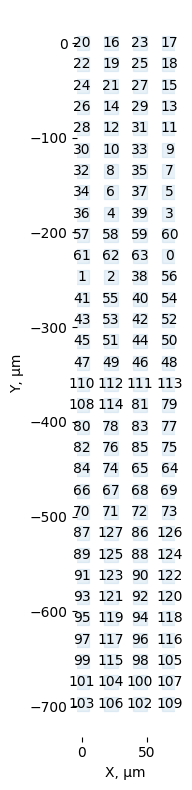

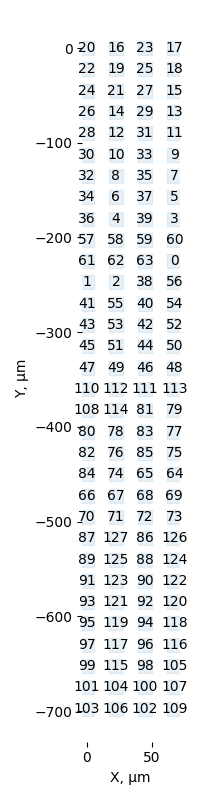

In [6]:
%matplotlib widget
plt.figure(figsize=(2,8))
plt.plot(*(df_probe.values.T[::]), 's', ms=10, alpha=0.1)
for (ch, (x,y)) in df_probe.iterrows():
    plt.text(x,y, ch, ha='center', va='center')
plt.box(False)
plt.xlabel('X, µm')
plt.ylabel('Y, µm')
plt.tight_layout()

display(plt.gcf())

# From SOFTWARE.docx file

In [7]:
sfreq = 30000 #Sampling_frequency (Hz) = 30 000 
Probe_numChannels = 128
Probe_dtype = np.uint16
Probe_voltage_step_size = 0.195e-6
Probe_y_digitization = 32768
Juxta_numChannels = 8
Juxta_dtype = np.uint16
Juxta_ADC_used_channel = 0
Juxta_Gain = 100
Juxta_y_digitization=65536
Juxta_y_range=10
distance_min_um = 29 #distance_min (µm) = 29
Probe_closest_electrode = 99
neuroseeker_px_size_um = 22.5 

In [8]:
# 2015_09_03_Cell9.0

# Load data from bin files into a matrix of n channels x m samples 
def loadRawData(filename, numChannels, dtype):
    fdata = np.fromfile(filename, dtype=dtype)
    
    assert(len(fdata)%numChannels == 0), 'improper channel number'
    
    numsamples = len(fdata) // numChannels
    
    data = np.reshape(fdata, (numsamples, numChannels))
    return (np.transpose(data))

## Read Juxta record

In [9]:
%%time

###Open ADC file ###

juxta = loadRawData('adc2015-09-03T21_18_47.bin',
                    numChannels = Juxta_numChannels, 
                    dtype = Juxta_dtype)[Juxta_ADC_used_channel, :].astype('float64')
juxta *= (Juxta_y_range /( Juxta_y_digitization * Juxta_Gain)) * 1e6
juxta_times = np.arange(len(juxta))/sfreq

CPU times: user 168 ms, sys: 324 ms, total: 492 ms
Wall time: 494 ms


## Whole record view

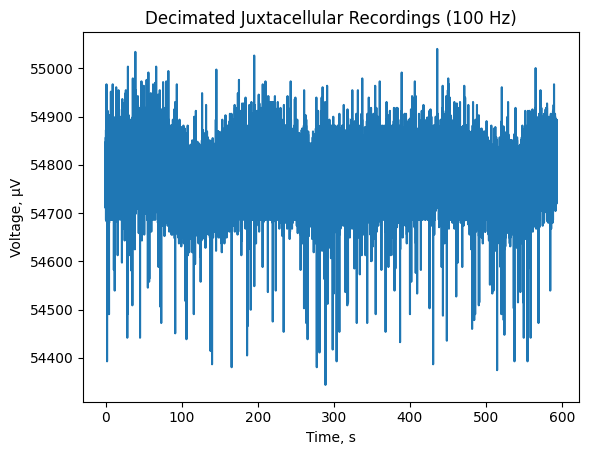

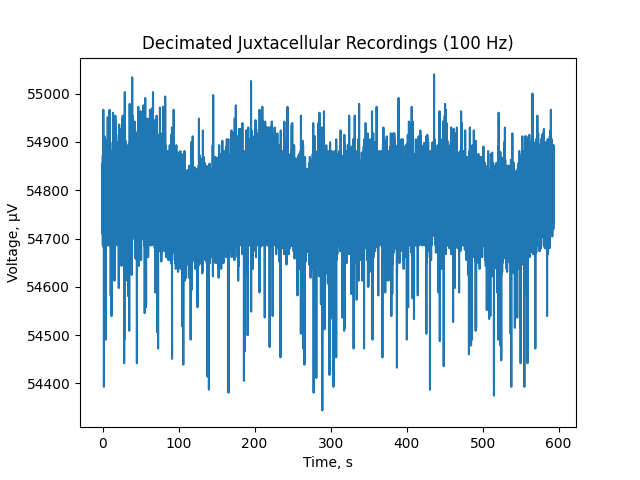

In [10]:
plt.figure()
plt.plot(juxta_times[::300], juxta[::300])
plt.xlabel('Time, s')
plt.ylabel('Voltage, µV')
plt.title('Decimated Juxtacellular Recordings (100 Hz)')

display(plt.gcf())

## Chunk view

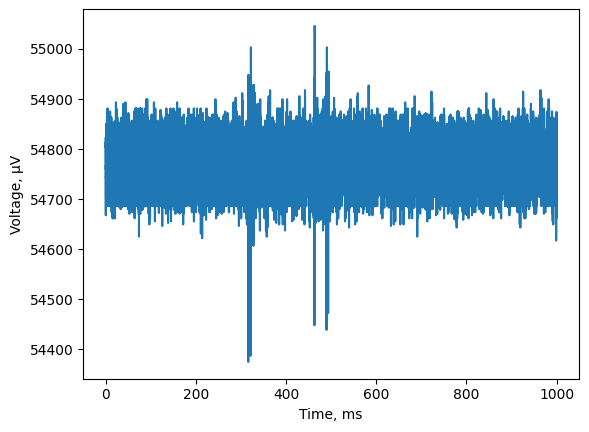

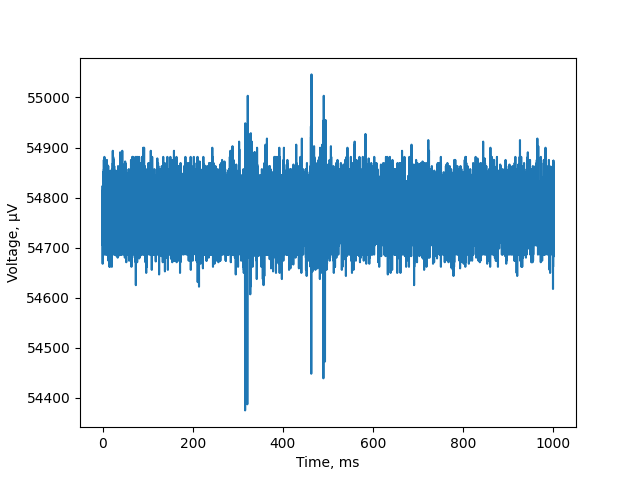

In [11]:
plt.figure()
plt.plot(juxta_times[juxta_times<1]*1000, juxta[juxta_times<1])
plt.xlabel('Time, ms')
plt.ylabel('Voltage, µV')

display(plt.gcf())

# Probe readings

In [12]:
%%time

### Open Amplifier file ###

# memory mapping to lower memory trace
# extra = np.memmap('amplifier2015-09-03T21_18_47-001.bin', dtype=Probe_dtype, mode='r').reshape(-1, Probe_numChannels).T

extra = loadRawData('amplifier2015-09-03T21_18_47-001.bin', 
                    numChannels = Probe_numChannels, 
                    dtype = Probe_dtype).astype('float64')
extra -= Probe_y_digitization
extra *= Probe_voltage_step_size

CPU times: user 24.2 s, sys: 1min 27s, total: 1min 51s
Wall time: 2min 42s


In [13]:
assert(juxta.shape[0] == extra.shape[-1])
print('We\'re lucky as hell!!!!!!!')

times = juxta_times

We're lucky as hell!!!!!!!


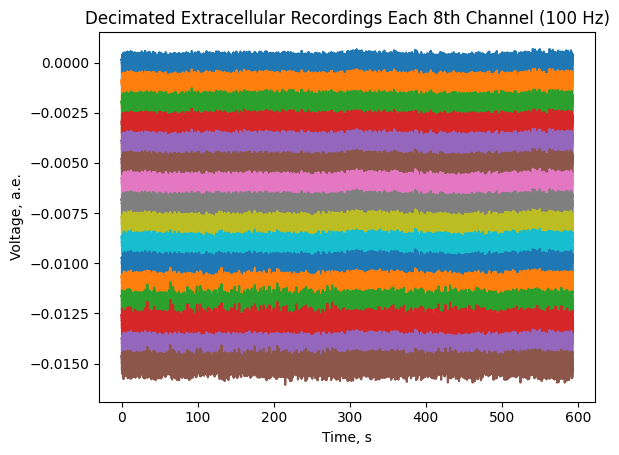

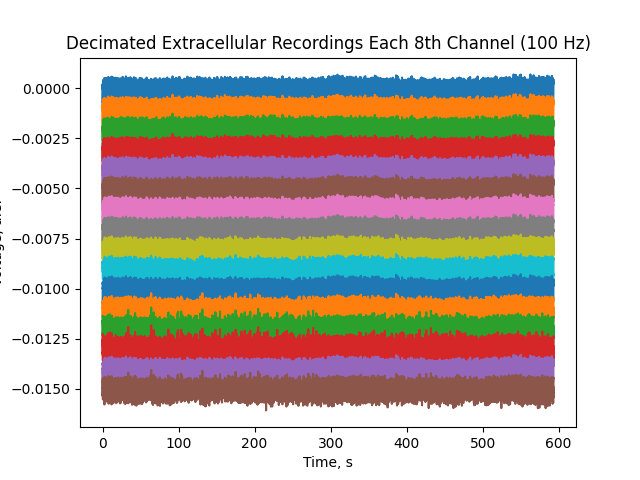

In [14]:
plt.figure()

plt.plot(times[::300], extra[::8, ::300].T - np.arange(128//8)*1e-3)
plt.xlabel('Time, s')
plt.ylabel('Voltage, a.e.')
plt.title('Decimated Extracellular Recordings Each 8th Channel (100 Hz)')

display(plt.gcf())

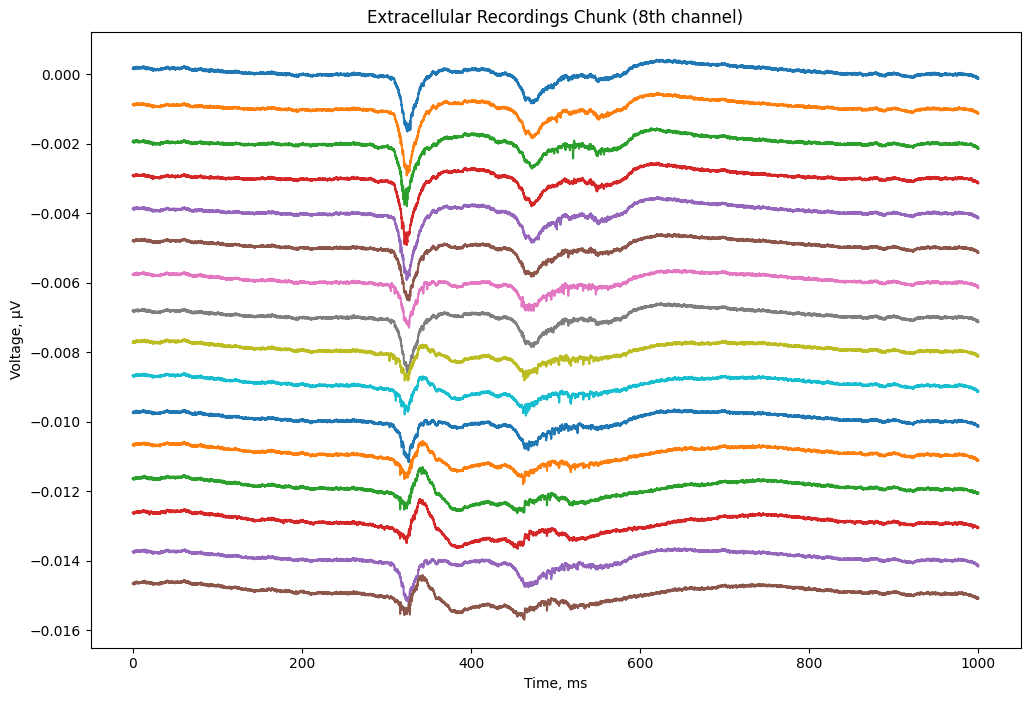

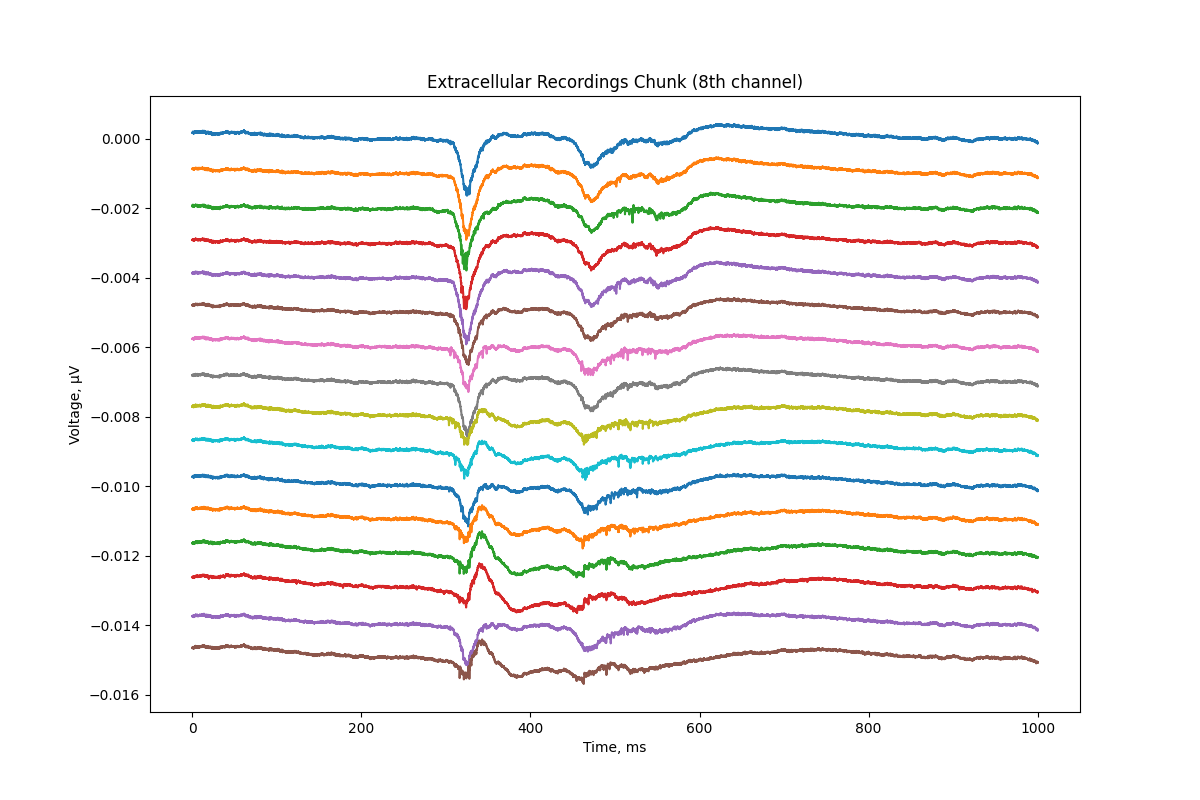

In [15]:
plt.figure(figsize=(12,8))
plt.plot(juxta_times[times<1]*1000, extra[::8, times<1].T - np.arange(128//8)*1e-3)
plt.xlabel('Time, ms')
plt.ylabel('Voltage, µV')
plt.title('Extracellular Recordings Chunk (8th channel)')

display(plt.gcf())

## Multimodal visualization

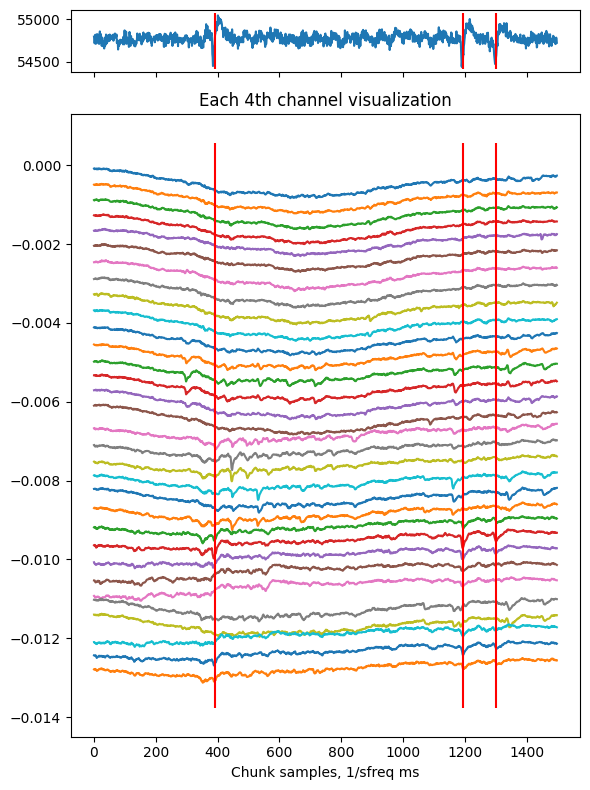

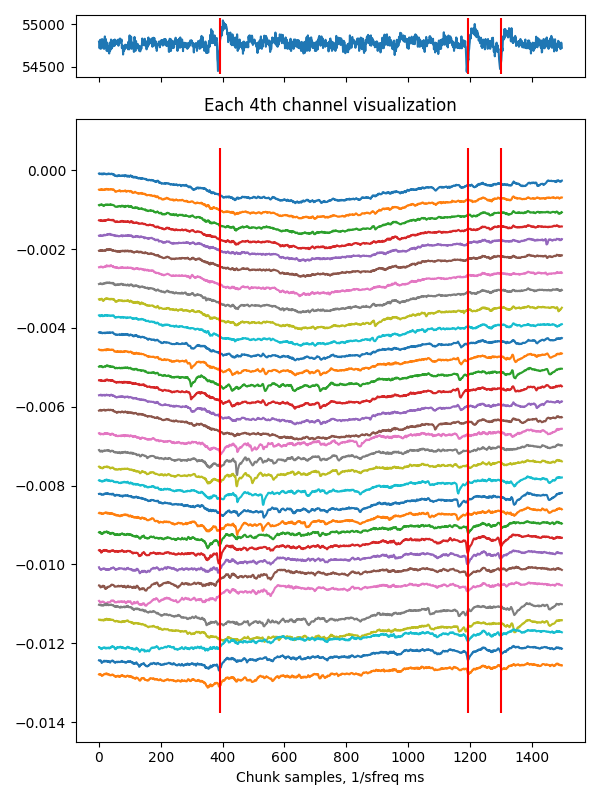

In [16]:
time_mask = ((times>0.45) * (times<0.5))

fig, axx = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': (1, 10)}, figsize=(6,8))
plt.sca(axx[0])
plt.plot(juxta[time_mask])
plt.vlines([391, 1194, 1301], *plt.ylim(), color='r')

plt.sca(axx[1])
plt.plot(extra[::4, time_mask].T - np.arange(Probe_numChannels)[::4]*1e-4);
plt.vlines([391, 1194, 1301], *plt.ylim(), color='r')

plt.xlabel('Chunk samples, 1/sfreq ms')
plt.title('Each 4th channel visualization')
plt.tight_layout()

display(plt.gcf())

# Forward problem: ground truth spike -> extracellular spike

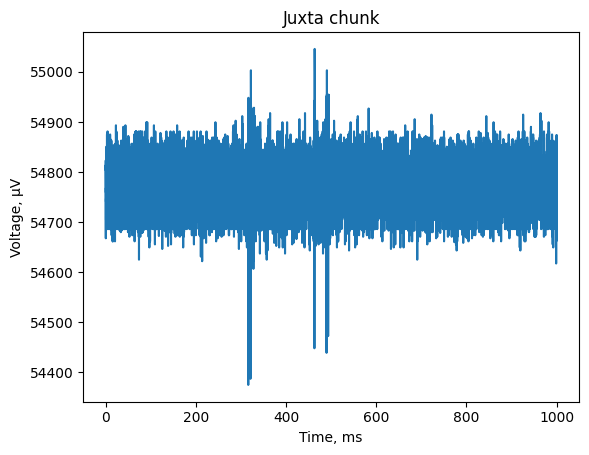

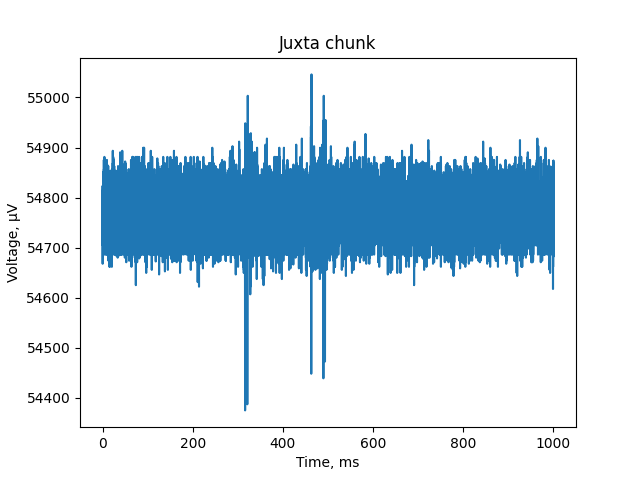

In [17]:
plt.figure()
plt.plot(juxta_times[juxta_times<1]*1000, juxta[juxta_times<1])
plt.xlabel('Time, ms')
plt.ylabel('Voltage, µV')
plt.title('Juxta chunk')

display(plt.gcf())

## How to find the proper threshold line? Statistics!

n-sigma threshold approach:

$t = \frac{x - <x>}{\sigma(x)}$ - t-statistics  

$t < n$  for negative deviation  
$t > n$  for positive deviation  
$abs(t) > n$  for any deviation

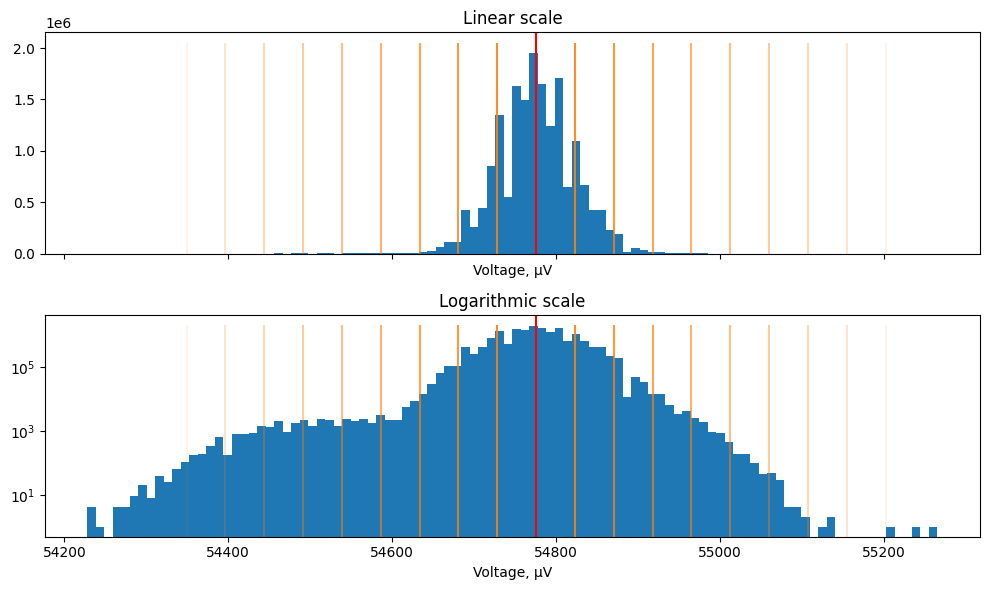

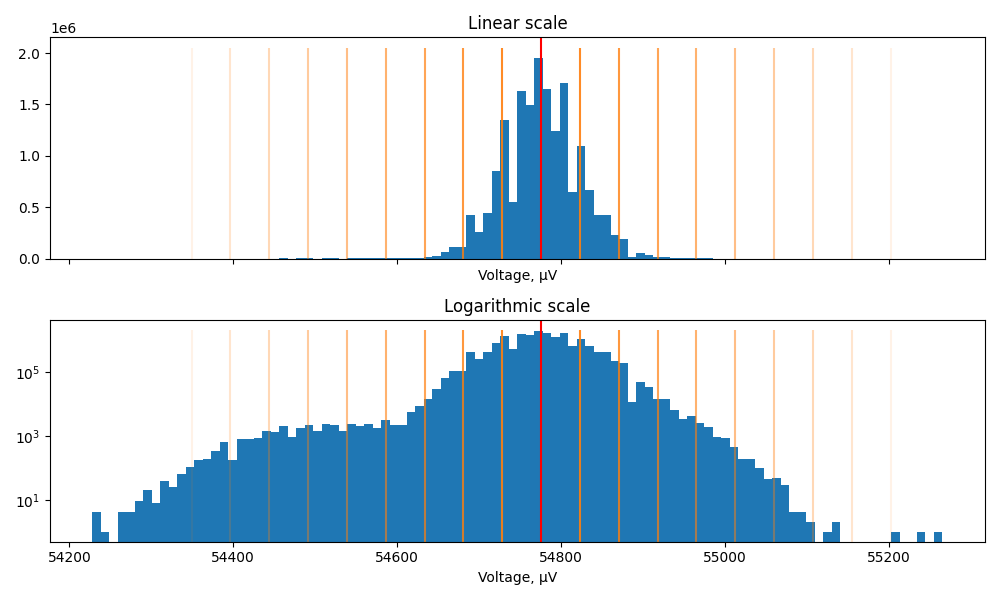

In [18]:
juxta_mean = juxta.mean()
juxta_std = juxta.std()

fig, axx = plt.subplots(2,1, sharex=True, figsize=(10,6))
plt.sca(axx[0])
plt.hist(juxta, bins=100);
plt.axvline(juxta_mean, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_std + juxta_mean, s*juxta_std + juxta_mean], *yl, color='C1', alpha=1-s/10)
plt.xlabel('Voltage, µV')
plt.title('Linear scale')

plt.sca(axx[1])
plt.hist(juxta, bins=100);
plt.axvline(juxta_mean, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_std + juxta_mean, s*juxta_std + juxta_mean], *yl, color='C1', alpha=1-s/10)
plt.xlabel('Voltage, µV')
plt.yscale('log')
plt.title('Logarithmic scale')

plt.tight_layout()

display(plt.gcf())

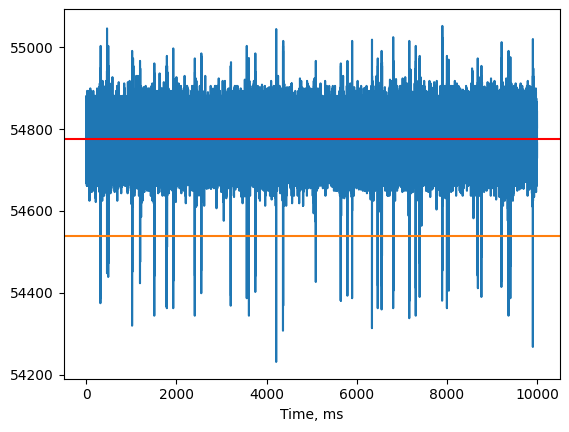

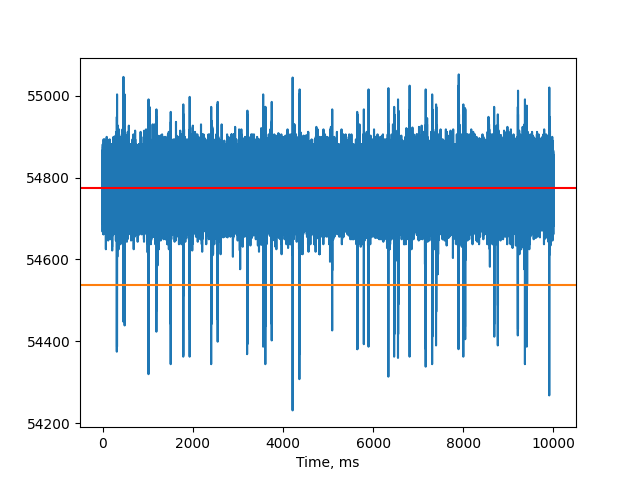

In [19]:
n_sigmas = 5

plt.figure()
plt.plot(juxta_times[juxta_times<10]*1000, juxta[juxta_times<10])
plt.axhline(juxta_mean, color='r')
plt.axhline(juxta_mean - juxta_std*n_sigmas, color='C1')
plt.xlabel('Time, ms')

display(plt.gcf())

## Look closer - We need preprocessing!!!

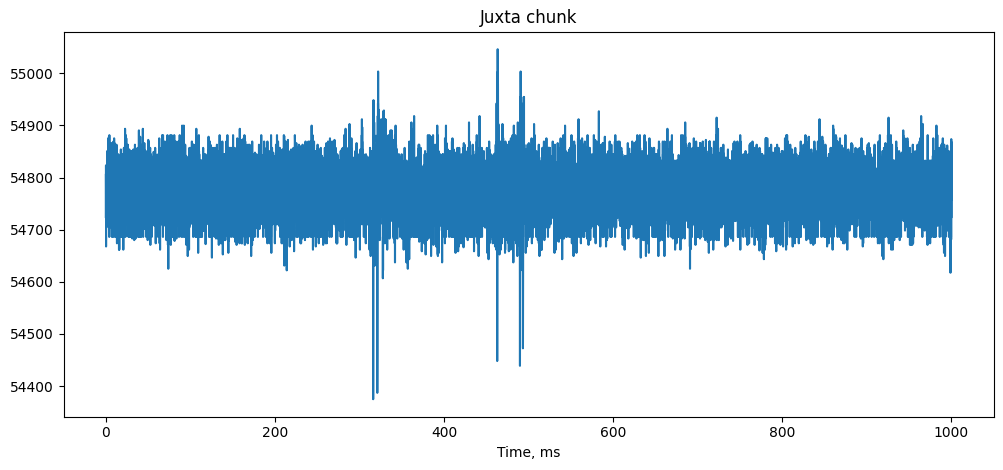

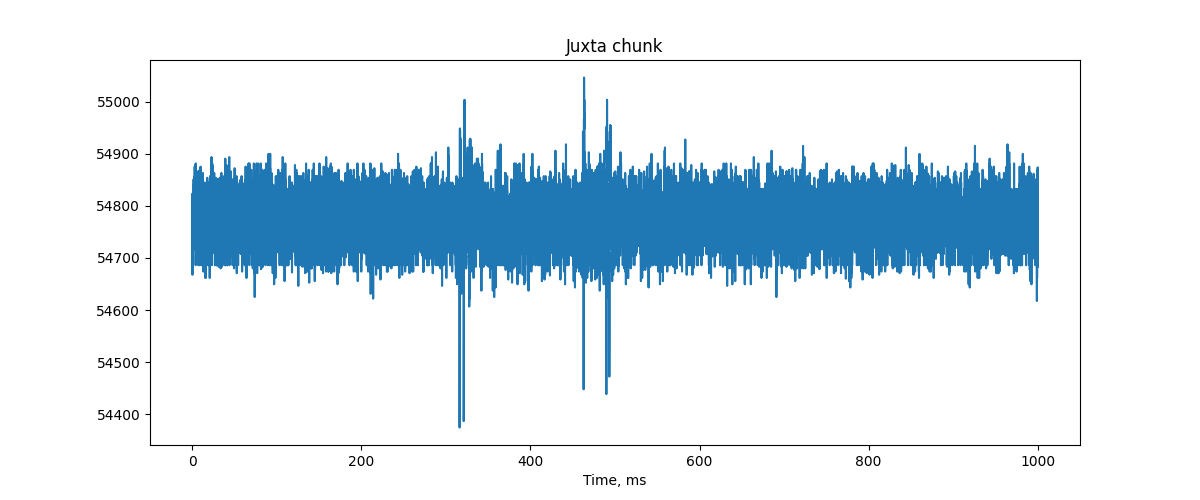

In [20]:
plt.figure(figsize=(12,5))
plt.plot(juxta_times[juxta_times<1]*1000, juxta[juxta_times<1])
plt.xlabel('Time, ms')
plt.title('Juxta chunk')

display(plt.gcf())

In [21]:
import mne

## How to filter? - analyze spectrum

In [22]:
%%time
psd, freqs = mne.time_frequency.psd_array_welch(juxta, sfreq, fmin=1, fmax=sfreq/2, n_fft=1024)

Effective window size : 0.034 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1.02 s, sys: 622 ms, total: 1.64 s
Wall time: 2.12 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


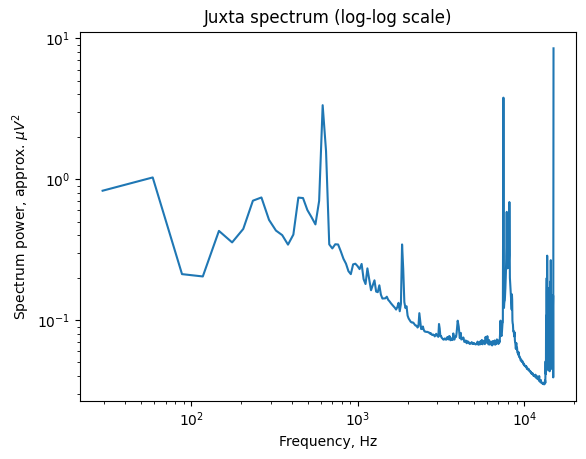

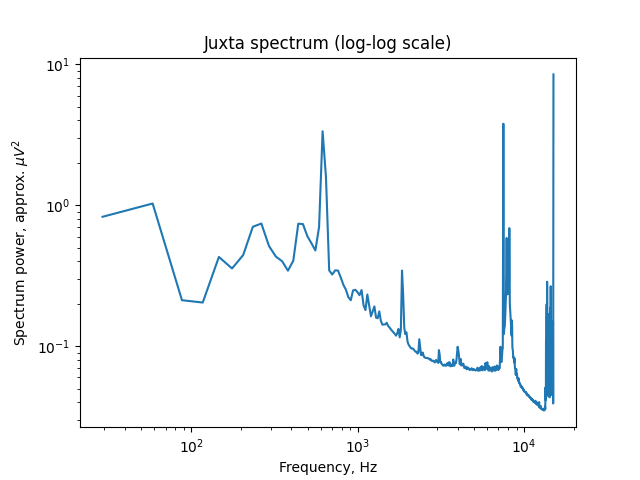

In [23]:
plt.figure()
plt.plot(freqs, psd)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency, Hz')
plt.ylabel('Spectrum power, approx. $µV^{2}$')
plt.title('Juxta spectrum (log-log scale)')

display(plt.gcf())

Setting up band-pass filter from 1e+02 - 4.5e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 4500.00 Hz
- Upper transition bandwidth: 1125.00 Hz (-6 dB cutoff frequency: 5062.50 Hz)
- Filter length: 3961 samples (0.132 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


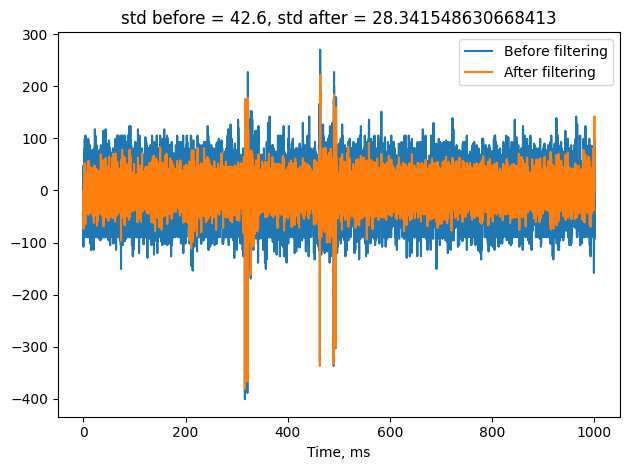

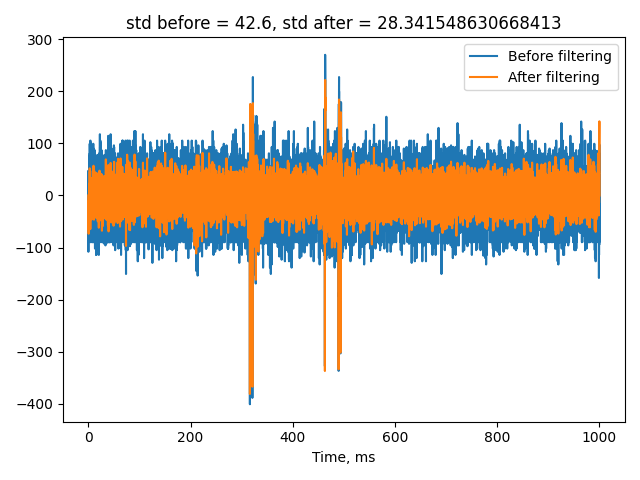

In [24]:
trace = juxta[juxta_times<1].copy()
trace_times = juxta_times[juxta_times<1]*1000

trace_std = trace.std()

plt.figure()
plt.plot(trace_times, trace-juxta_mean)

mne.filter.filter_data(trace, sfreq, l_freq=100, h_freq=4500, copy=False)

plt.plot(trace_times, trace)

plt.xlabel('Time, ms')

plt.legend(['Before filtering', 'After filtering'])

plt.title(f'std before = {trace_std:.1f}, std after = {trace.std()}')

plt.tight_layout()

display(plt.gcf())

Setting up band-pass filter from 1e+02 - 4.5e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 4500.00 Hz
- Upper transition bandwidth: 1125.00 Hz (-6 dB cutoff frequency: 5062.50 Hz)
- Filter length: 3961 samples (0.132 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


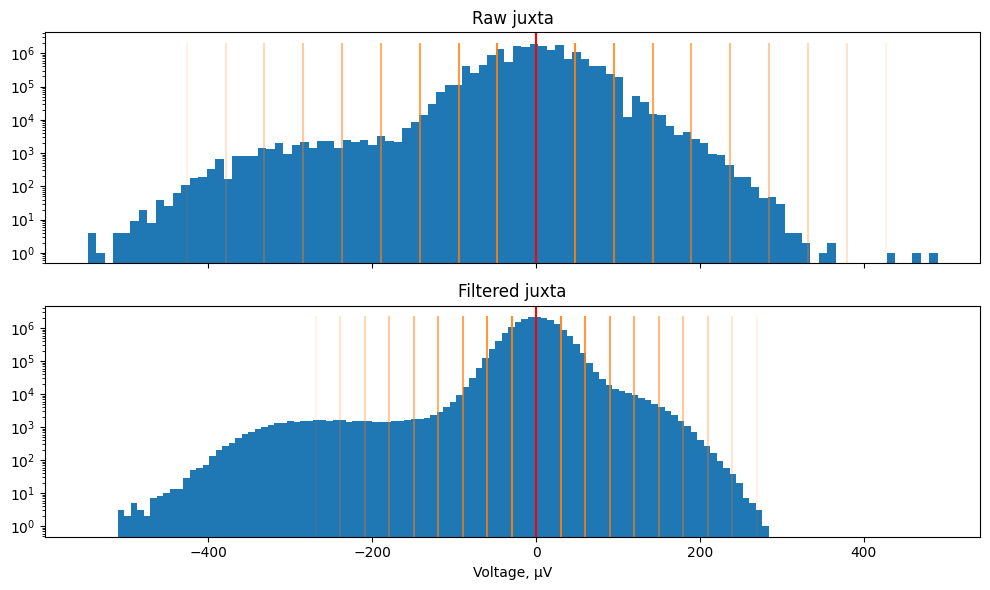

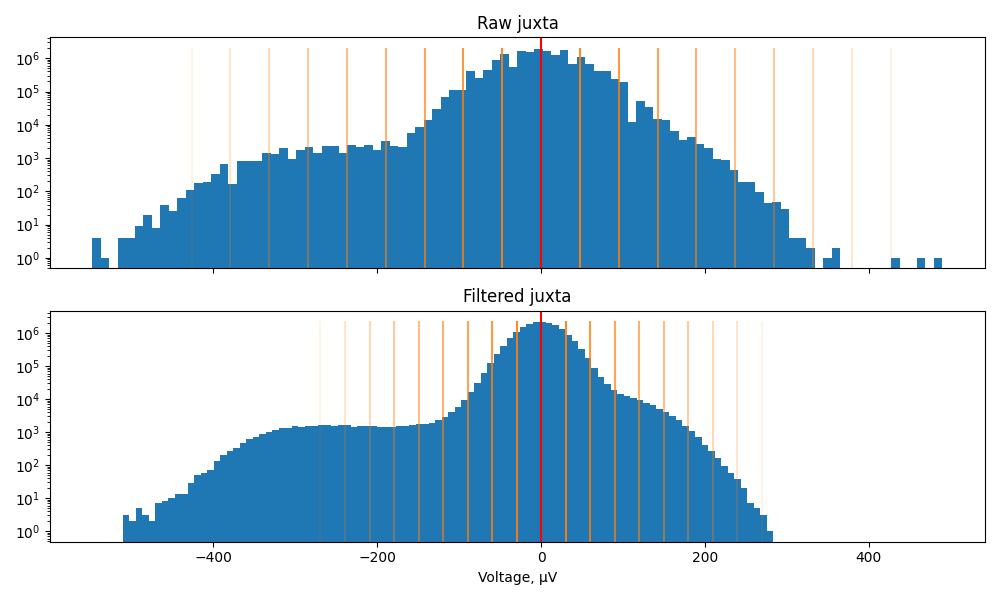

In [25]:
juxta_filt = mne.filter.filter_data(juxta, sfreq, l_freq=100, h_freq=4500)

juxta_mean = juxta.mean()
juxta_std = juxta.std()

juxta_filt_mean = juxta_filt.mean()
juxta_filt_std = juxta_filt.std()

fig, axx = plt.subplots(2,1, sharex=True, figsize=(10,6))
plt.sca(axx[0])
plt.hist(juxta-juxta_mean, bins=100);
plt.axvline(0, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_std, s*juxta_std], *yl, color='C1', alpha=1-s/10)
plt.yscale('log')
plt.title('Raw juxta')

plt.sca(axx[1])
plt.hist(juxta_filt, bins=100);
plt.axvline(juxta_filt_mean, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*juxta_filt_std + juxta_filt_mean, s*juxta_filt_std + juxta_filt_mean], *yl, color='C1', alpha=1-s/10)
plt.xlabel('Voltage, µV')
plt.yscale('log')
plt.title('Filtered juxta')

plt.tight_layout()

display(plt.gcf())

## Then we will work with filtered trace

## Now — segmentation

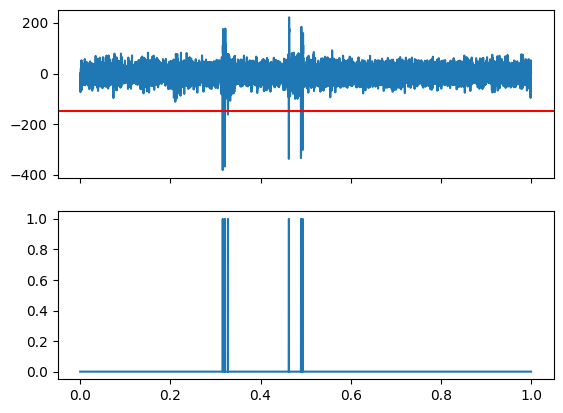

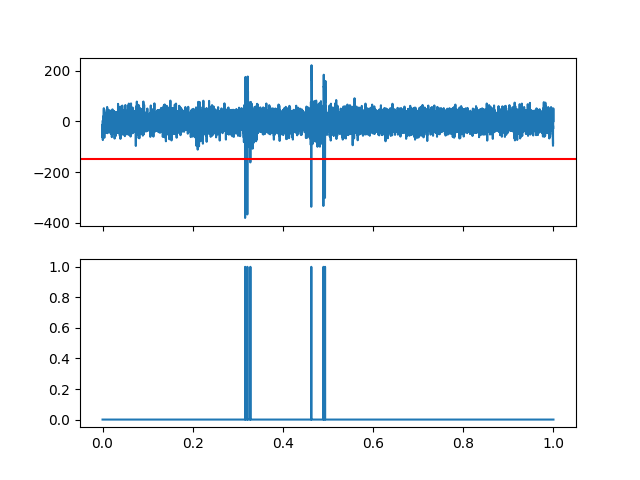

In [26]:
juxta_thresh = -(juxta_filt_std * 5)

mask = juxta_filt < juxta_thresh

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[times<1], juxta_filt[times<1])
plt.axhline(juxta_thresh, color='r')

plt.sca(axx[1])
plt.plot(times[times<1], mask[times<1])

display(plt.gcf())

## Mask correction with binary closing

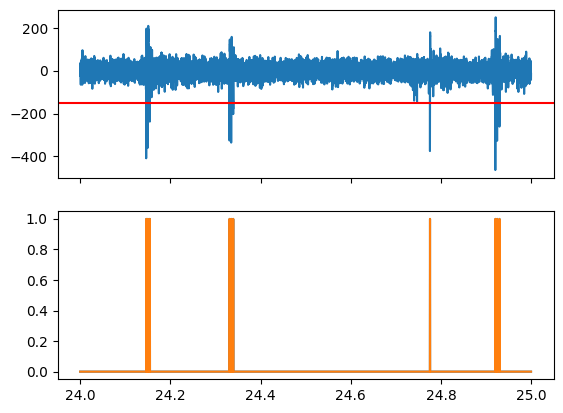

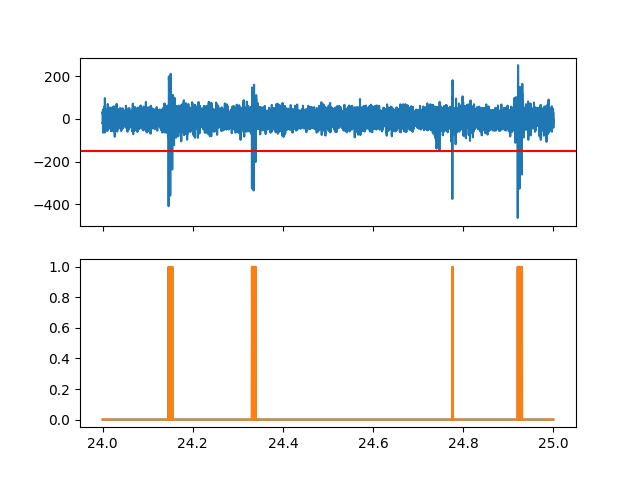

In [27]:
from scipy.ndimage import binary_closing

juxta_thresh = -(juxta_filt_std * 5)

mask = juxta_filt < juxta_thresh

time_mask = (times>24) & (times<25)

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[time_mask], juxta_filt[time_mask])
plt.axhline(juxta_thresh, color='r')

plt.sca(axx[1])
plt.plot(times[time_mask], mask[time_mask])

mask_close = binary_closing(mask, np.ones(int(500e-6 * sfreq)))

plt.sca(axx[1])
plt.plot(times[time_mask], mask_close[time_mask])


display(plt.gcf())

## Segmentation — finding edges

In [28]:
# ensure we have no boundary effects

assert(not mask_close[0])
assert(not mask_close[-1])


In [29]:
onsets = np.where(np.diff(mask_close.astype(int), prepend=0)>0)[0]
offsets = np.where(np.diff(mask_close.astype(int), prepend=0)<0)[0]


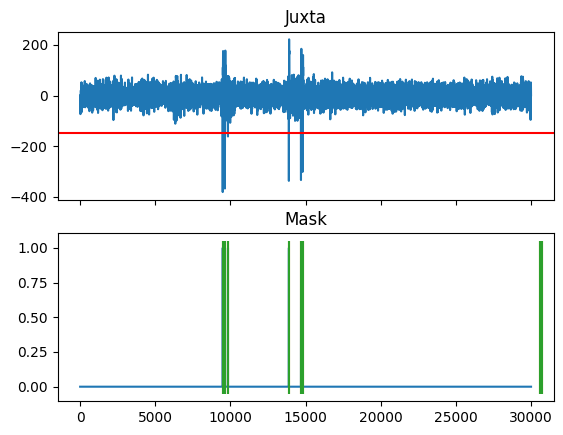

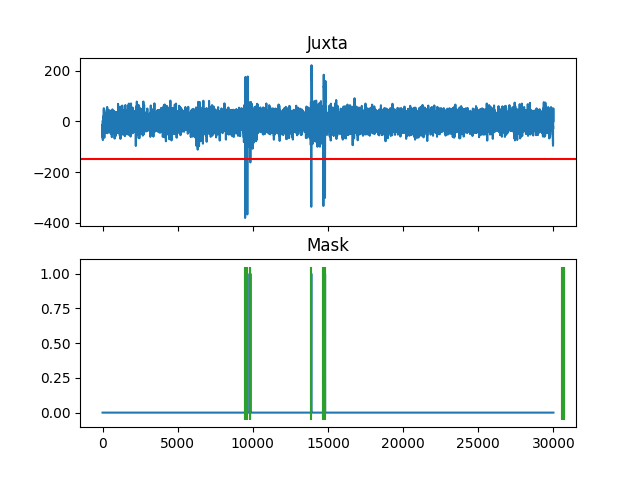

In [30]:
from scipy.ndimage import binary_closing

time_mask = (times<1)

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(juxta_filt[time_mask])
plt.axhline(juxta_thresh, color='r')
plt.title('Juxta')

plt.sca(axx[1])
plt.plot(mask_close[time_mask])
plt.title('Mask')
yl = plt.ylim()
xl = plt.xlim()
plt.vlines(onsets, *yl, color='C1')
plt.vlines(offsets, *yl, color='C2')
plt.xlim(xl)


display(plt.gcf())

In [31]:
df_regions = pd.DataFrame({'Onset' : onsets, 
                           'Offset': offsets}).astype(int)
df_regions

Onset    Offset
0         9481      9489
1         9629      9637
2         9833      9837
3        13884     13890
4        14690     14698
...        ...       ...
5017  17784491  17784500
5018  17784613  17784622
5019  17788451  17788459
5020  17788556  17788564
5021  17789748  17789756

[5022 rows x 2 columns]

## Find peaks and locations

In [32]:
# similar to skimage.measure.regionprops but faster as we work in 1d



In [33]:
df_regions['Peak'] = df_regions.apply(lambda row: juxta_filt[row.Onset: row.Offset].argmin() + row.Onset, 
                                      axis=1).astype(int)
df_regions


Onset    Offset      Peak
0         9481      9489      9485
1         9629      9637      9632
2         9833      9837      9835
3        13884     13890     13886
4        14690     14698     14692
...        ...       ...       ...
5017  17784491  17784500  17784495
5018  17784613  17784622  17784617
5019  17788451  17788459  17788455
5020  17788556  17788564  17788559
5021  17789748  17789756  17789751

[5022 rows x 3 columns]

In [34]:
df_regions['Amplitude_uV'] = juxta_filt[df_regions.Peak.values]
df_regions


Onset    Offset      Peak  Amplitude_uV
0         9481      9489      9485   -381.334085
1         9629      9637      9632   -367.402225
2         9833      9837      9835   -161.876045
3        13884     13890     13886   -337.190903
4        14690     14698     14692   -333.893542
...        ...       ...       ...           ...
5017  17784491  17784500  17784495   -351.438278
5018  17784613  17784622  17784617   -294.095954
5019  17788451  17788459  17788455   -390.950773
5020  17788556  17788564  17788559   -291.468410
5021  17789748  17789756  17789751   -337.204335

[5022 rows x 4 columns]

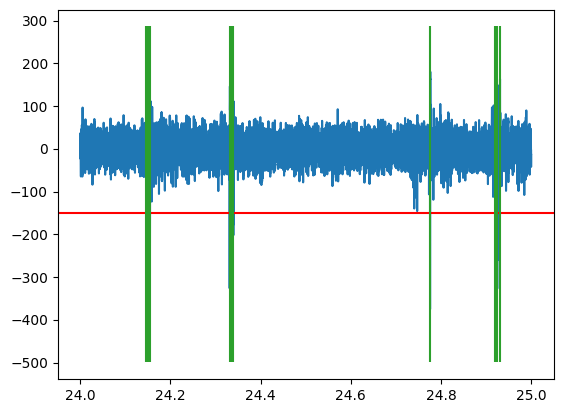

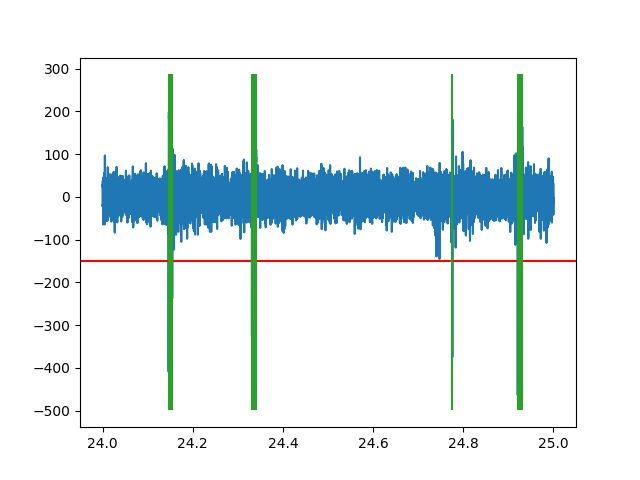

In [35]:
from scipy.ndimage import binary_closing

mask = juxta_filt < juxta_thresh
mask_close = binary_closing(mask, np.ones(int(500e-6 * sfreq)))

time_mask = (times>24) & (times<25)

fig, axx = plt.subplots(1,1, sharex=True)

plt.plot(times[time_mask], juxta_filt[time_mask])
plt.axhline(juxta_thresh, color='r')
xl = plt.xlim()

plt.vlines(times[df_regions.Peak.values], *plt.ylim(), color='C2')

plt.xlim(xl )

display(plt.gcf())

# Collecting samples of juxtacellular spikes

In [36]:
window_ms = 5
window_half_ts = int(window_ms * sfreq/1000)//2 + 1
window_times_us = np.arange(-window_half_ts, window_half_ts, 1)*1e6/sfreq # just for plotting purposes

juxta_samples = np.stack([juxta_filt[int(row.Peak) - window_half_ts: int(row.Peak) + window_half_ts] 
                          for irow, row in df_regions.iterrows()], 
                         axis=0)
juxta_samples.shape



(5022, 152)

In [37]:
# save for later statistics

In [38]:
juxta_mask = mask_close.copy()
df_regions_juxta = df_regions.copy()


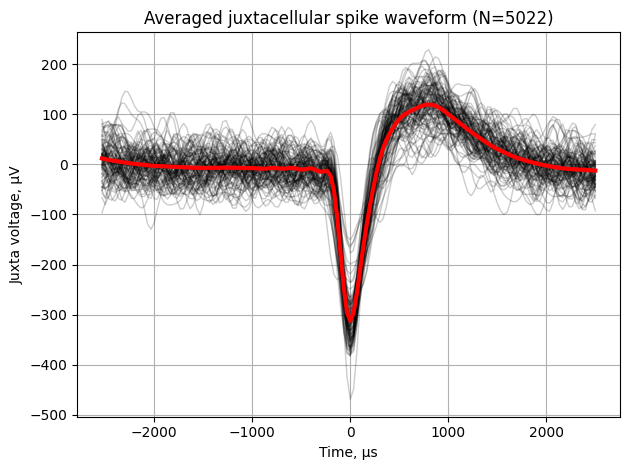

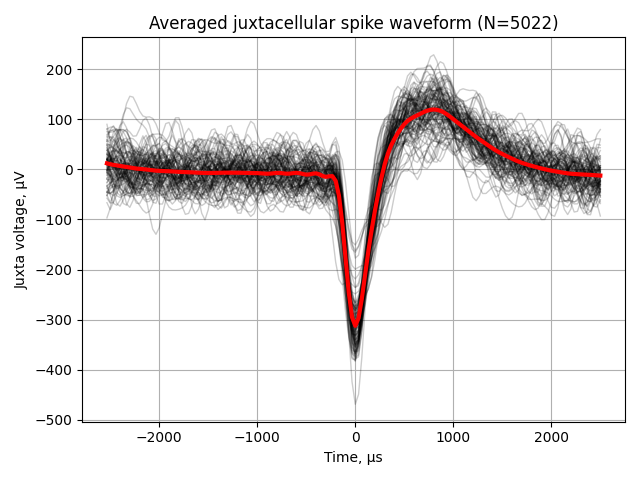

In [39]:
juxta_samples_mean = juxta_samples.mean(0)

plt.figure()
plt.plot(window_times_us, juxta_samples[::50].T, color='k', alpha=0.2, lw=1)
plt.plot(window_times_us, juxta_samples_mean, color='r', lw=3)
plt.title(f'Averaged juxtacellular spike waveform (N={len(juxta_samples)})')

plt.xlabel('Time, µs')
plt.ylabel('Juxta voltage, µV')
plt.grid(True)

plt.tight_layout()

display(plt.gcf())

### Some spike statistics

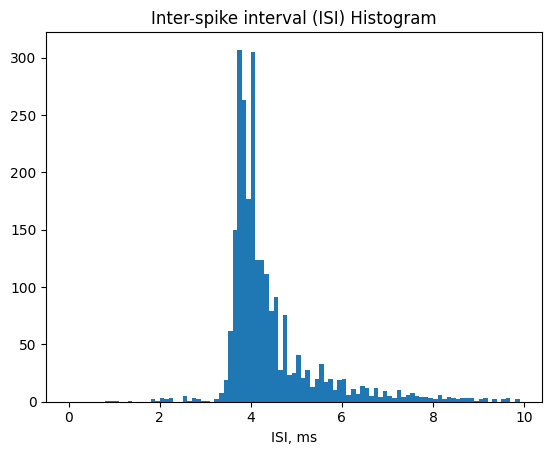

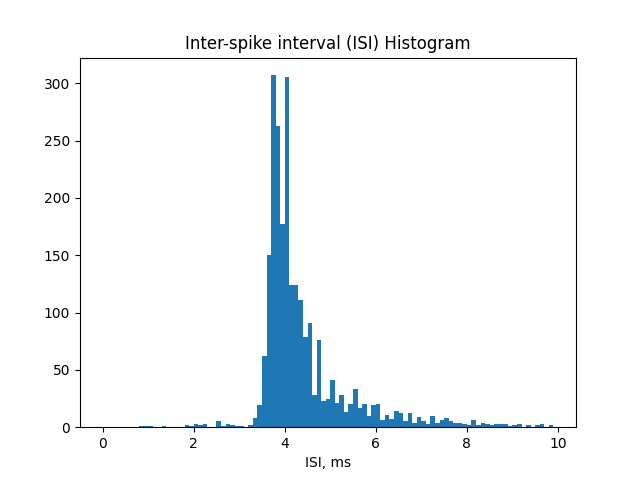

In [40]:
plt.figure()
plt.hist(np.diff(df_regions.Peak.values)*1000/sfreq, bins=np.arange(0, 10, 0.1));
plt.title('Inter-spike interval (ISI) Histogram')
plt.xlabel('ISI, ms')

display(plt.gcf())

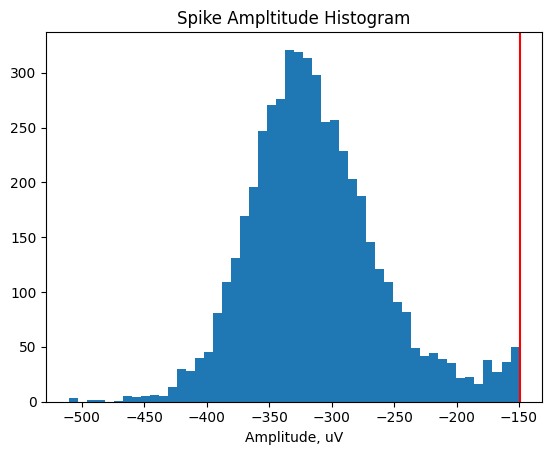

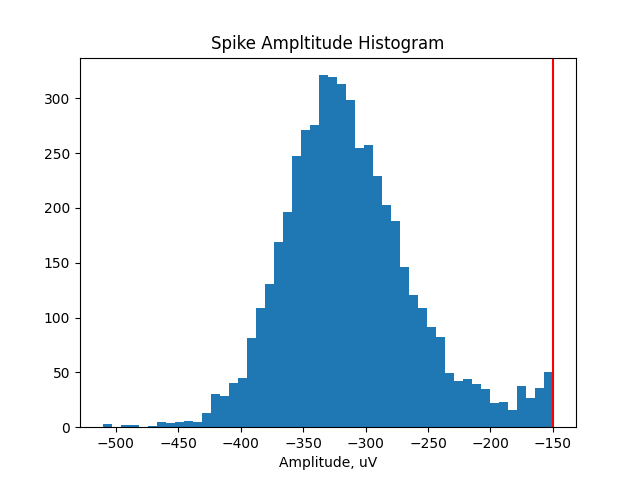

In [41]:
plt.figure()
plt.hist((df_regions.Amplitude_uV), bins=50);
plt.title('Spike Ampltitude Histogram')
plt.xlabel('Amplitude, uV')
plt.axvline(juxta_thresh, color='r')

display(plt.gcf())

# Collecting samples of extracellular spikes

In [42]:
%%time


from tqdm.autonotebook import tqdm
extra_samples = np.stack([extra[:, int(row.Peak) - window_half_ts: int(row.Peak) + window_half_ts] 
                          for irow, row in tqdm(df_regions.iterrows(), total=len(df_regions))], 
                        axis=0)
    

<timed exec>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/5022 [00:00<?, ?it/s]

CPU times: user 851 ms, sys: 1.89 s, total: 2.74 s
Wall time: 4.92 s


In [43]:
extra_samples.shape


(5022, 128, 152)

## Postprocess

In [44]:
%%time

# Remove drifts and shifts

extra_samples_detrend = mne.filter.detrend(extra_samples)


CPU times: user 8.29 s, sys: 3.41 s, total: 11.7 s
Wall time: 6.37 s


In [45]:
extra_samples_mean = extra_samples_detrend.mean(0)
extra_samples_mean.shape


(128, 152)

<ipython-input-46-add9adf607e0>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,10))


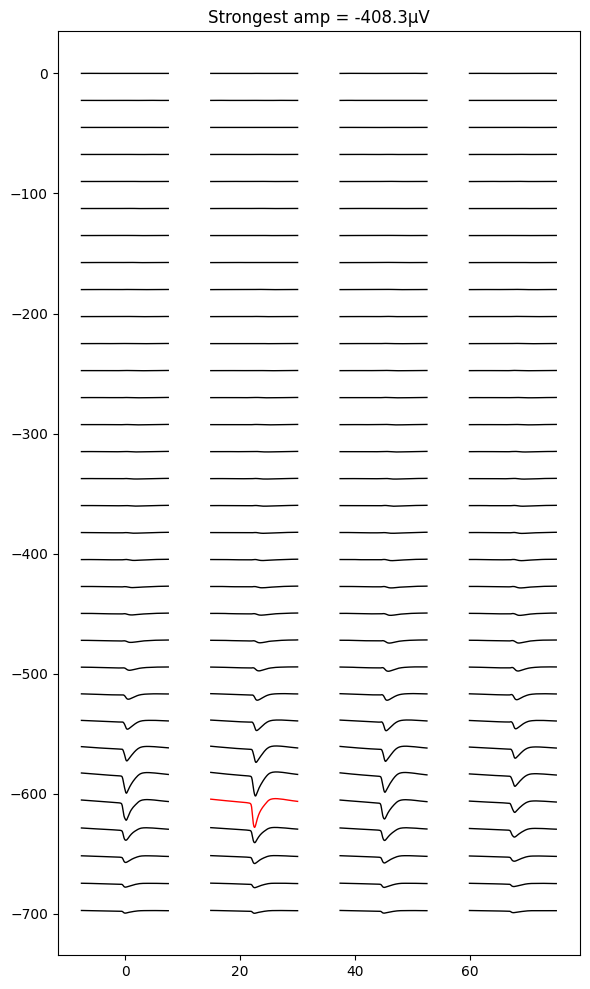

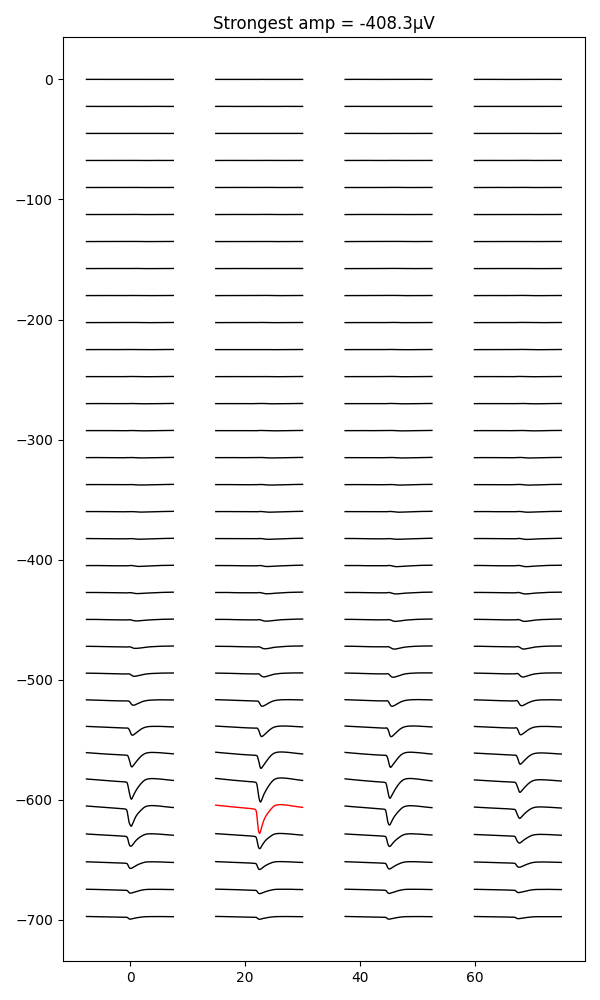

In [46]:

n_strongest_channel = extra_samples_mean[:, window_half_ts].argmin()
strongest_amplitude = extra_samples_mean[n_strongest_channel, window_half_ts]

plt.figure(figsize=(6,10))
time_scale = 3e-3
voltage_scale = 5e4

for irow, row in df_probe.iterrows():
    if irow == n_strongest_channel:
        c = 'r'
    else:
        c = 'k'
    plt.plot(window_times_us*time_scale + row.x,  
             extra_samples_mean[irow]*voltage_scale + row.y, 
             color=c, 
             lw=1)
    
plt.title(f'Strongest amp = {strongest_amplitude*1e6:.1f}µV')
plt.tight_layout()


display(plt.gcf())

In [47]:
extra_samples_from_juxta = extra_samples.copy()


In [48]:
extra_samples_mean.min(-1).argmin()

119

## Extracellular Spike Analysis

Elephant package

https://elephant.readthedocs.io/en/latest/reference/current_source_density.html



In [49]:
# %pip install elephant


In [50]:
col_2_idx = df_probe.query('x == 22.5').sort_values(by='y', ascending=False).index


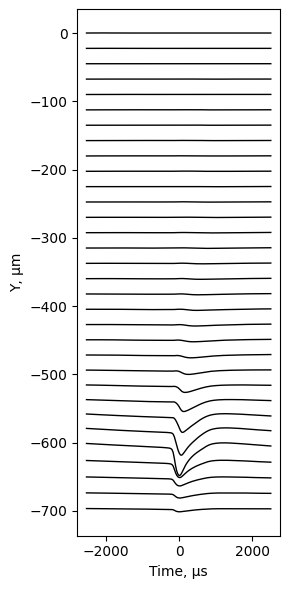

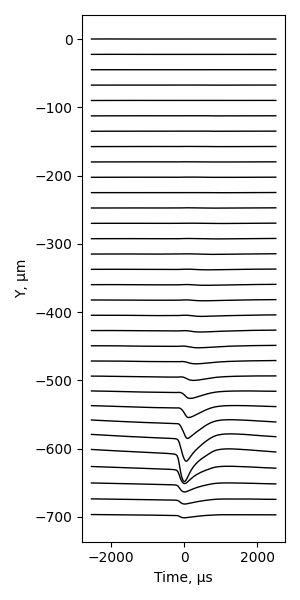

In [51]:
coords = df_probe.loc[col_2_idx, 'y']

plt.figure(figsize=(3,6))
plt.plot(window_times_us, extra_samples_mean[col_2_idx, :].T*1e5 + coords.values, 
         color='k', lw=1)

plt.xlabel('Time, µs')
plt.tight_layout()
plt.ylabel('Y, µm')
plt.tight_layout()

display(plt.gcf())


In [52]:

import elephant
import neo
import quantities as pq

analog = neo.AnalogSignal(extra_samples_mean[col_2_idx, :].T, 
                          units=pq.uV, 
                          sampling_rate=sfreq*pq.Hz)

csd = elephant.current_source_density.estimate_csd(lfp = analog, 
                                                     coordinates=df_probe.loc[col_2_idx, 'y'].values.reshape(-1,1)*pq.um, 
                                                     method='StandardCSD', process_estimate=False)

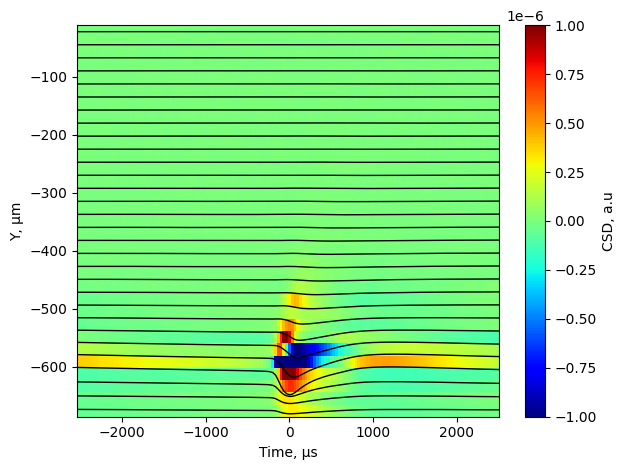

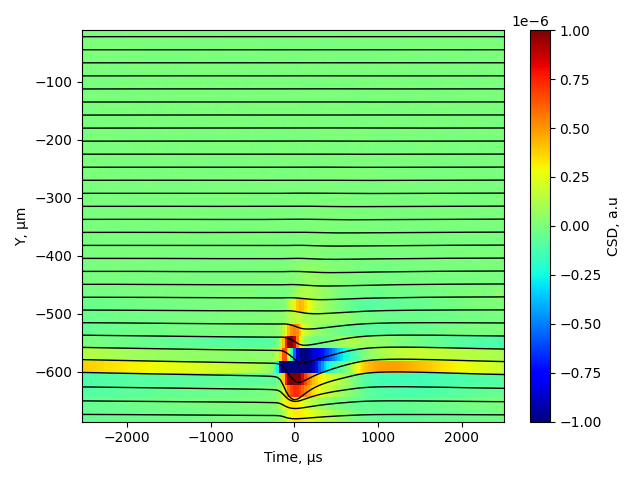

In [53]:
plt.figure()

plt.plot(window_times_us, extra_samples_mean[col_2_idx, :].T*1e5 +coords.values, 
         color='k', lw=1)

plt.imshow(csd.T, aspect='auto', 
           extent=(window_times_us[0], 
                   window_times_us[-1], 
                   coords.min()+11.25, 
                   coords.max()-11.25), 
           zorder=-1, 
           vmin=-1e-6, vmax=1e-6, cmap='jet',
           interpolation='nearest')
plt.colorbar(label='CSD, a.u')
plt.xlabel('Time, µs')
plt.ylabel('Y, µm')
plt.tight_layout()

display(plt.gcf())

# Inverse problem: Spike Clustering

But lets stick to one channel first

In [54]:
extra.shape

(128, 17797440)

In [55]:
extra_idx = 119 # from previous studies
extra_trace = extra[119]
df_probe.iloc[119]


x     22.5
y   -607.5
Name: 119, dtype: float64

## Compare extra and juxta

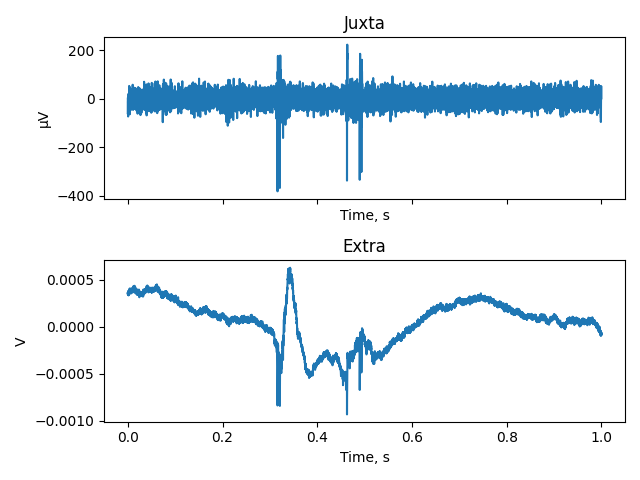

In [56]:
from scipy.ndimage import binary_closing

time_mask = times<1

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[time_mask], juxta_filt[time_mask])
plt.xlabel('Time, s')
plt.ylabel('µV')
plt.title('Juxta')

plt.sca(axx[1])
plt.plot(times[time_mask], extra_trace[time_mask])
plt.title('Extra')
plt.xlabel('Time, s')
plt.ylabel('V')
plt.tight_layout()

## Filter Extra

In [57]:
sfreq

30000

In [58]:
extra_trace_filt = mne.filter.filter_data(extra_trace, sfreq=sfreq, l_freq=300, h_freq=3000)


Setting up band-pass filter from 3e+02 - 3e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 300.00
- Lower transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 262.50 Hz)
- Upper passband edge: 3000.00 Hz
- Upper transition bandwidth: 750.00 Hz (-6 dB cutoff frequency: 3375.00 Hz)
- Filter length: 1321 samples (0.044 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


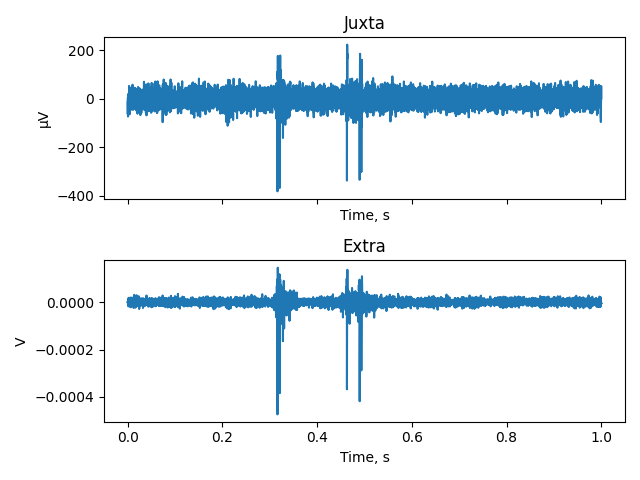

In [59]:
from scipy.ndimage import binary_closing

time_mask = times<1

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[time_mask], juxta_filt[time_mask])
plt.xlabel('Time, s')
plt.ylabel('µV')
plt.title('Juxta')

plt.sca(axx[1])
plt.plot(times[time_mask], extra_trace_filt[time_mask])
plt.title('Extra')
plt.xlabel('Time, s')
plt.ylabel('V')
plt.tight_layout()

## Mask calculation

In [60]:
extra_mean = extra_trace_filt.mean()
extra_std = extra_trace_filt.std()
extra_mean, extra_std


(-3.5135450338485405e-12, 2.239020939219597e-05)

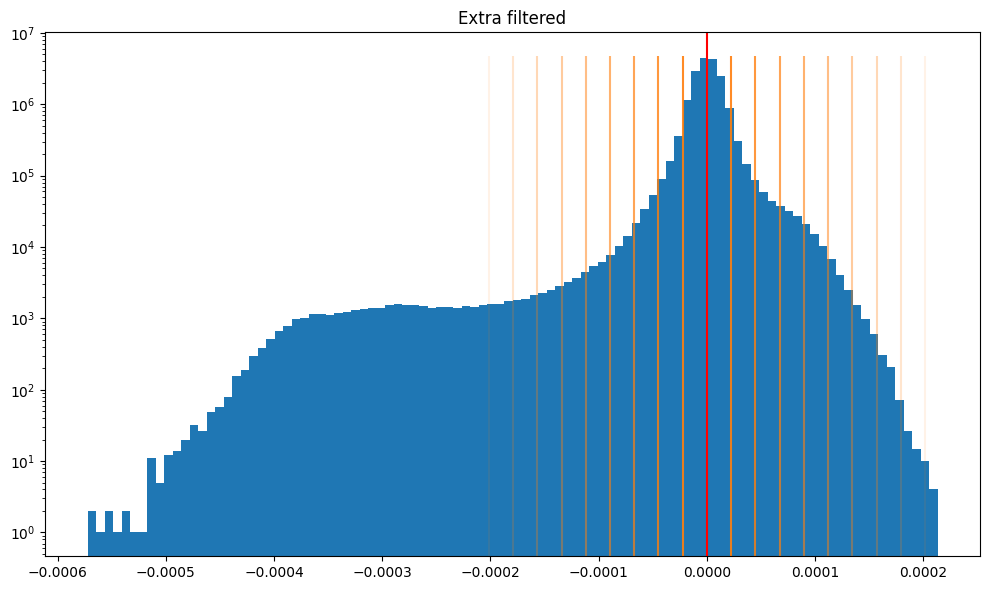

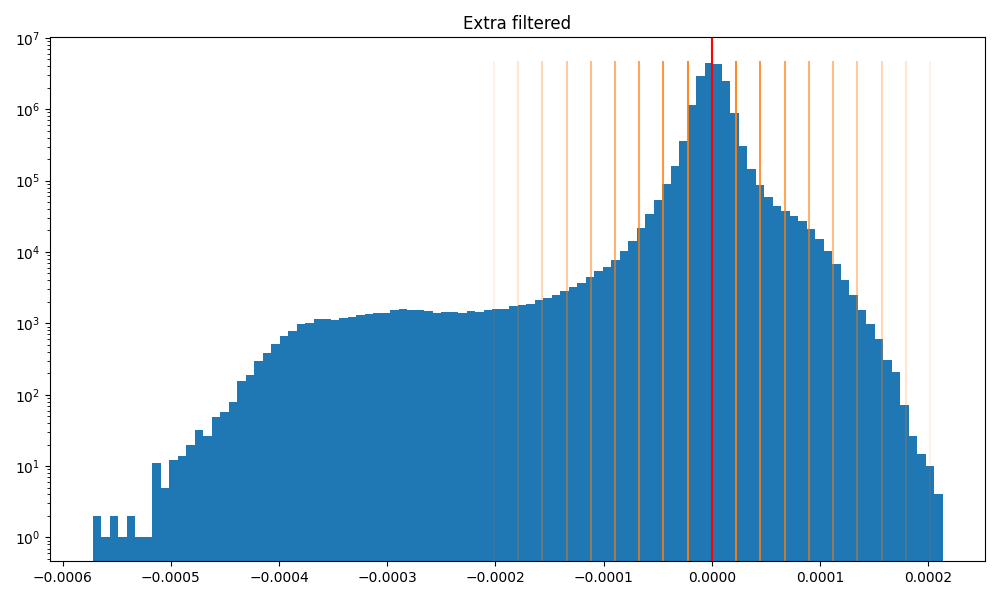

In [61]:
fig, axx = plt.subplots(1,1, sharex=True, figsize=(10,6))

plt.hist(extra_trace_filt, bins=100);
plt.axvline(0, color='r')

yl = plt.ylim()
for s in np.arange(1,10):
    plt.vlines([-s*extra_std, s*extra_std], *yl, color='C1', alpha=1-s/10)
plt.yscale('log')
plt.title('Extra filtered')

plt.tight_layout()

display(plt.gcf())

In [62]:
extra_thresh = -7*extra_std


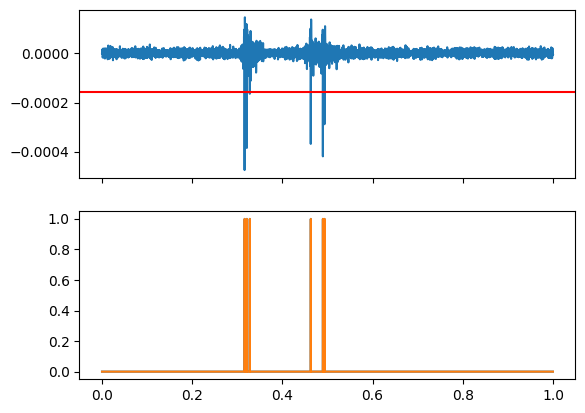

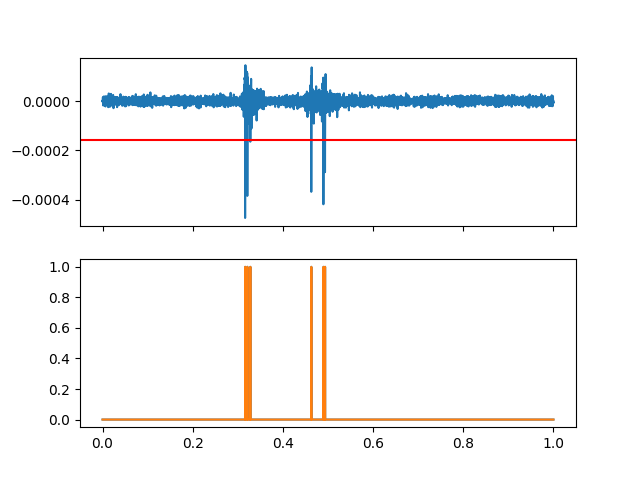

In [63]:
from scipy.ndimage import binary_closing

mask = extra_trace_filt < extra_thresh

time_mask = times<1

fig, axx = plt.subplots(2,1, sharex=True)
plt.sca(axx[0])
plt.plot(times[time_mask], extra_trace_filt[time_mask])
plt.axhline(extra_thresh, color='r')

plt.sca(axx[1])
plt.plot(times[time_mask], mask[time_mask])

mask_close = binary_closing(mask, np.ones(int(500e-6 * sfreq)))

plt.sca(axx[1])
plt.plot(times[time_mask], mask_close[time_mask])


display(plt.gcf())

## Segmentation

In [64]:
onsets = np.where(np.diff(mask_close.astype(int), prepend=0)>0)[0]
offsets = np.where(np.diff(mask_close.astype(int), prepend=0)<0)[0]


In [65]:
assert(len(onsets) == len(offsets))


In [66]:
df_regions = pd.DataFrame({'Onset' : onsets, 
                           'Offset': offsets}).astype(int)
df_regions

Onset    Offset
0         9481      9491
1         9629      9639
2         9830      9835
3        13884     13893
4        14689     14699
...        ...       ...
4954  17784492  17784501
4955  17784613  17784623
4956  17788452  17788463
4957  17788556  17788567
4958  17789748  17789758

[4959 rows x 2 columns]

In [67]:
df_regions['Peak'] = df_regions.apply(lambda row: extra_trace_filt[row.Onset: row.Offset].argmin() + row.Onset, 
                                      axis=1).astype(int)
df_regions

Onset    Offset      Peak
0         9481      9491      9485
1         9629      9639      9632
2         9830      9835      9832
3        13884     13893     13887
4        14689     14699     14693
...        ...       ...       ...
4954  17784492  17784501  17784495
4955  17784613  17784623  17784617
4956  17788452  17788463  17788455
4957  17788556  17788567  17788560
4958  17789748  17789758  17789751

[4959 rows x 3 columns]

In [68]:
df_regions['Amplitude_uV'] = extra_trace_filt[df_regions.Peak.values]
df_regions

Onset    Offset      Peak  Amplitude_uV
0         9481      9491      9485     -0.000474
1         9629      9639      9632     -0.000384
2         9830      9835      9832     -0.000165
3        13884     13893     13887     -0.000368
4        14689     14699     14693     -0.000418
...        ...       ...       ...           ...
4954  17784492  17784501  17784495     -0.000408
4955  17784613  17784623  17784617     -0.000353
4956  17788452  17788463  17788455     -0.000381
4957  17788556  17788567  17788560     -0.000313
4958  17789748  17789758  17789751     -0.000393

[4959 rows x 4 columns]

In [69]:
window_ms = 5
window_half_ts = int(window_ms * sfreq/1000)//2 + 1
window_times_us = np.arange(-window_half_ts, window_half_ts, 1)*1e6/sfreq # just for plotting purposes

extra_samples = np.stack([extra_trace[int(row.Peak) - window_half_ts: int(row.Peak) + window_half_ts] 
                          for irow, row in df_regions.iterrows()], 
                         axis=0)

mne.filter

extra_samples.shape

(4959, 152)

In [70]:
extra_mask = mask_close.copy()
df_regions_extra = df_regions.copy()
extra_samples_from_extra = extra_samples.copy()


## Compare to juxta

In [71]:
intersection_over_union = (np.logical_and(juxta_mask, extra_mask).sum())/(np.logical_or(juxta_mask, extra_mask).sum())

intersection_over_union


0.7652369255316915

In [72]:
extra_samples.shape, juxta_samples.shape

((4959, 152), (5022, 152))

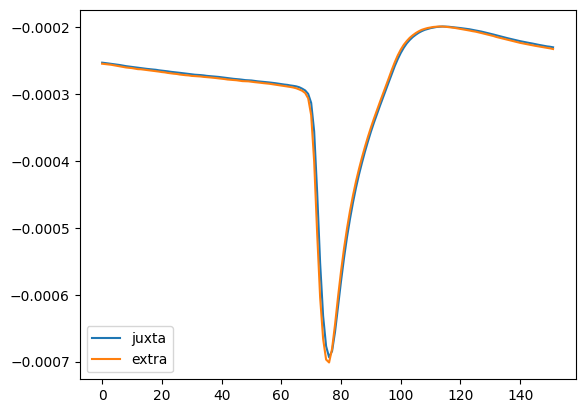

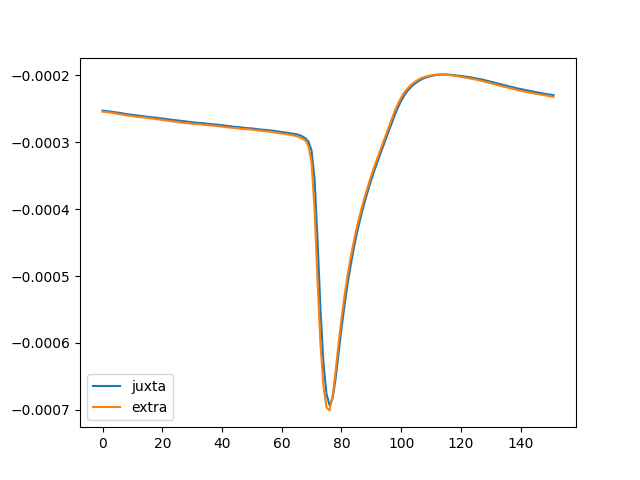

In [73]:
plt.figure()
plt.plot(extra_samples_from_juxta.mean(0)[extra_idx], label='juxta')
plt.plot(extra_samples_from_extra.mean(0), label='extra')
plt.legend()
display(plt.gcf())


# What if we don't know the extra_ch

In [74]:
df_probe.query('x==22.5').sort_values('y', ascending=False)


x      y
channel             
16       22.5    0.0
19       22.5  -22.5
21       22.5  -45.0
14       22.5  -67.5
12       22.5  -90.0
10       22.5 -112.5
8        22.5 -135.0
6        22.5 -157.5
4        22.5 -180.0
58       22.5 -202.5
62       22.5 -225.0
2        22.5 -247.5
55       22.5 -270.0
53       22.5 -292.5
51       22.5 -315.0
49       22.5 -337.5
112      22.5 -360.0
114      22.5 -382.5
78       22.5 -405.0
76       22.5 -427.5
74       22.5 -450.0
67       22.5 -472.5
71       22.5 -495.0
127      22.5 -517.5
125      22.5 -540.0
123      22.5 -562.5
121      22.5 -585.0
119      22.5 -607.5
117      22.5 -630.0
115      22.5 -652.5
104      22.5 -675.0
106      22.5 -697.5

In [75]:
extra_channels = df_probe.query('x==22.5').sort_values('y', ascending=False).index.values[::3] # reduce memory consumption
extra_channels, len(extra_channels)


(array([ 16,  14,   8,  58,  55,  49,  78,  67, 125, 119, 104]), 11)

In [76]:

extra_traces = np.stack([extra[c, times<60] for c in tqdm(extra_channels)], axis=0)



  0%|          | 0/11 [00:00<?, ?it/s]

In [77]:
local_times = times[times<60]



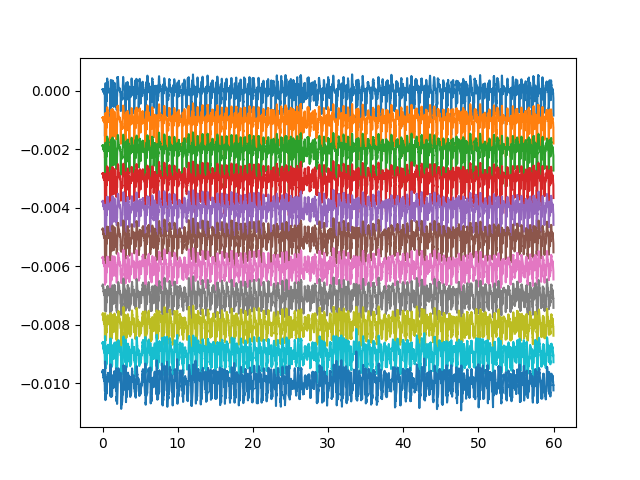

In [78]:
plt.figure()
plt.plot(local_times[::300], extra_traces[:, ::300].T - np.arange(len(extra_traces))*1e-3)



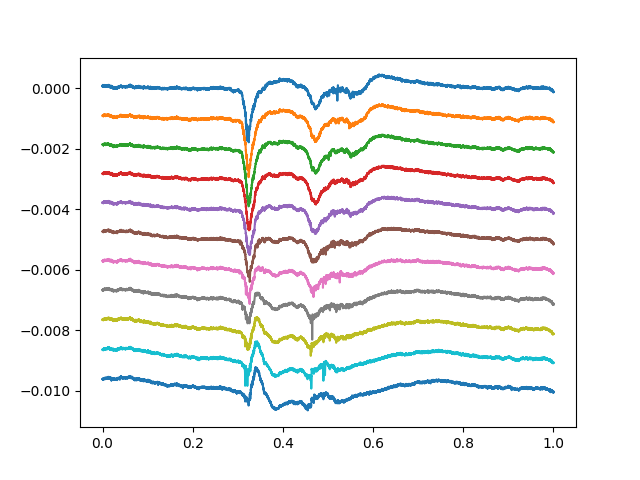

In [79]:
plt.figure()
plt.plot(local_times[local_times<1], extra_traces[:,local_times<1].T - np.arange(len(extra_traces))*1e-3)



In [80]:
extra_traces_filt = mne.filter.filter_data(extra_traces, sfreq=sfreq, l_freq=300, h_freq=3000)


Setting up band-pass filter from 3e+02 - 3e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 300.00
- Lower transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 262.50 Hz)
- Upper passband edge: 3000.00 Hz
- Upper transition bandwidth: 750.00 Hz (-6 dB cutoff frequency: 3375.00 Hz)
- Filter length: 1321 samples (0.044 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.8s finished


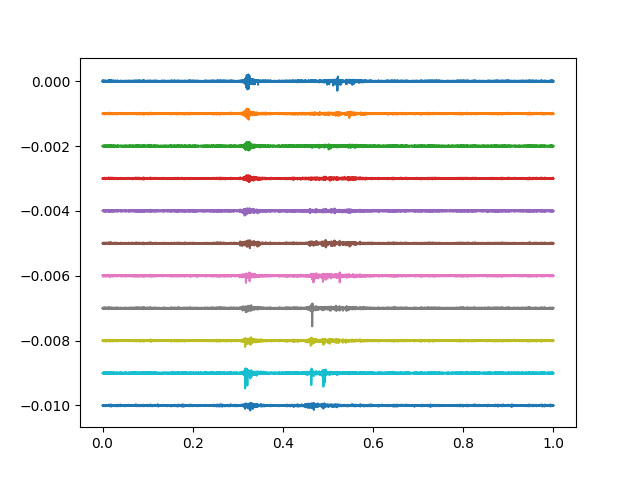

In [81]:
plt.figure()
plt.plot(local_times[local_times<1], extra_traces_filt[:,local_times<1].T - np.arange(len(extra_traces))*1e-3)


In [82]:
df_regions_ = []

for i, c in tqdm(enumerate(extra_traces_filt)):
    
    c_thresh = c.mean() - 7*c.std()
    mask = binary_closing(c < c_thresh, np.ones(int(500e-6 * sfreq)))
    
    assert(mask[0] == 0)
    assert(mask[-1] == 0)
    
    df_rps = pd.DataFrame({'Onset' : np.where(np.diff(mask.astype(int), prepend=0)>0)[0]-1,
                           'Offset': np.where(np.diff(mask.astype(int), prepend=0)>0)[0]}).astype(int)
    
    df_rps['Peak'] = df_rps.apply(lambda row: c[row["Onset"] : (row['Offset'])].argmin() + row['Onset'], axis=1)
    df_rps['Channel'] = extra_channels[i]
    
    df_regions_.append(df_rps)
    

0it [00:00, ?it/s]

In [83]:
df_regions = pd.concat(df_regions_).reset_index(drop=True)
df_regions = df_regions[df_regions.Onset>window_half_ts+1]
df_regions = df_regions[df_regions.Offset< len(local_times)-window_half_ts-1]
df_regions.reset_index(drop=True, inplace=True)
df_regions

Onset   Offset     Peak  Channel
0        9550     9551     9550       16
1        9597     9598     9597       16
2        9636     9637     9636       16
3        9715     9716     9715       16
4       15351    15352    15351       16
...       ...      ...      ...      ...
3536  1769437  1769438  1769437      104
3537  1781135  1781136  1781135      104
3538  1781392  1781393  1781392      104
3539  1781557  1781558  1781557      104
3540  1781823  1781824  1781823      104

[3541 rows x 4 columns]

In [84]:
extra_samples = np.stack([extra_traces[:, int(row.Peak) - window_half_ts: int(row.Peak) + window_half_ts] 
                          for irow, row in tqdm(df_regions.iterrows(), total=len(df_regions))], 
                        axis=0)


  0%|          | 0/3541 [00:00<?, ?it/s]

In [85]:
extra_samples_detrend = mne.filter.detrend(extra_samples)

extra_samples_detrend.shape


(3541, 11, 152)

In [86]:
X = extra_samples_detrend.reshape(len(extra_samples_detrend), -1)


In [90]:
X.shape

(3541, 1672)

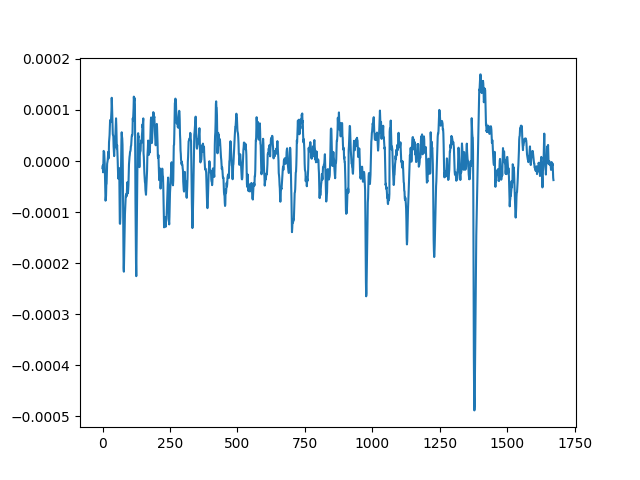

In [91]:
plt.figure()
plt.plot(X[0])

In [87]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=10)

tv = tsne.fit_transform(X)


/Users/mike/anaconda3/envs/2022_neurotech_course/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mike/anaconda3/envs/2022_neurotech_course/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3541 samples in 0.005s...
[t-SNE] Computed neighbors for 3541 samples in 0.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3541
[t-SNE] Computed conditional probabilities for sample 2000 / 3541
[t-SNE] Computed conditional probabilities for sample 3000 / 3541
[t-SNE] Computed conditional probabilities for sample 3541 / 3541
[t-SNE] Mean sigma: 0.000421
[t-SNE] Computed conditional probabilities in 0.241s
[t-SNE] Iteration 50: error = 81.9529953, gradient norm = 0.1391463 (50 iterations in 1.189s)
[t-SNE] Iteration 100: error = 78.1239624, gradient norm = 0.1177390 (50 iterations in 1.009s)
[t-SNE] Iteration 150: error = 77.2884064, gradient norm = 0.1318677 (50 iterations in 1.065s)
[t-SNE] Iteration 200: error = 76.8823013, gradient norm = 0.1016352 (50 iterations in 0.794s)
[t-SNE] Iteration 250: error = 77.3781738, gradient norm = 0.0998703 (50 iterations in 0.696s)
[t-SNE] KL divergence after 250 iterati

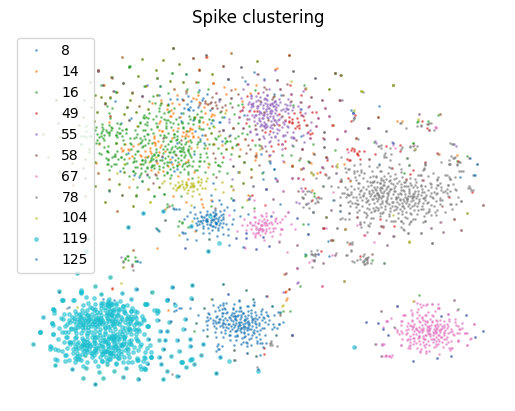

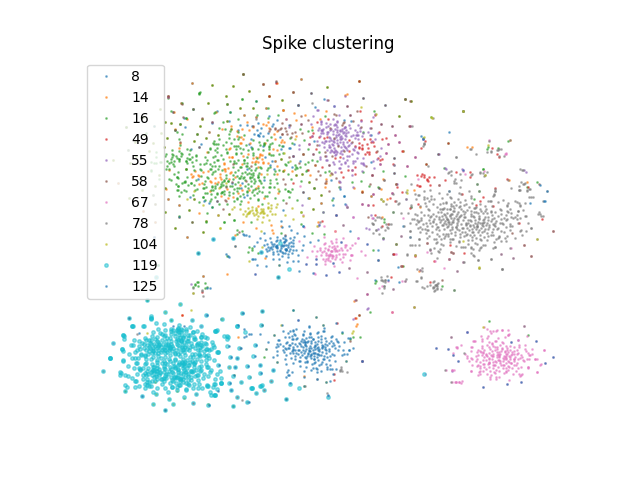

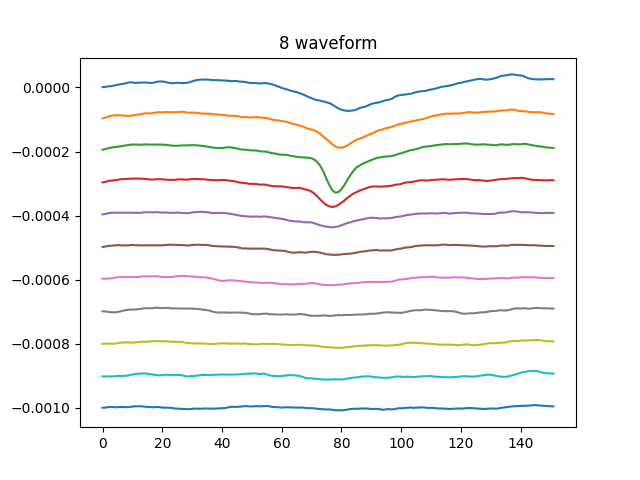

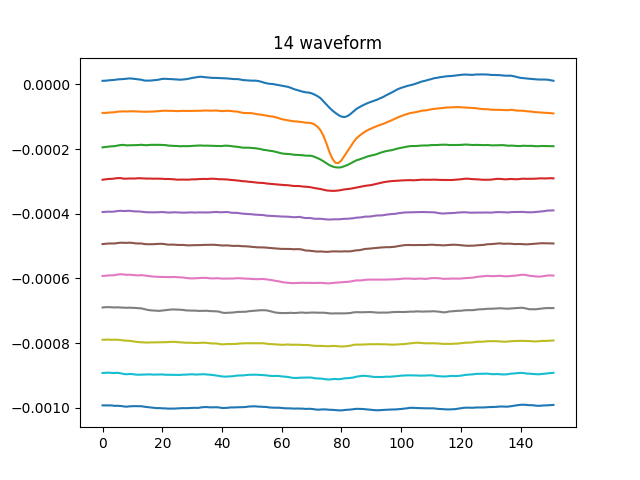

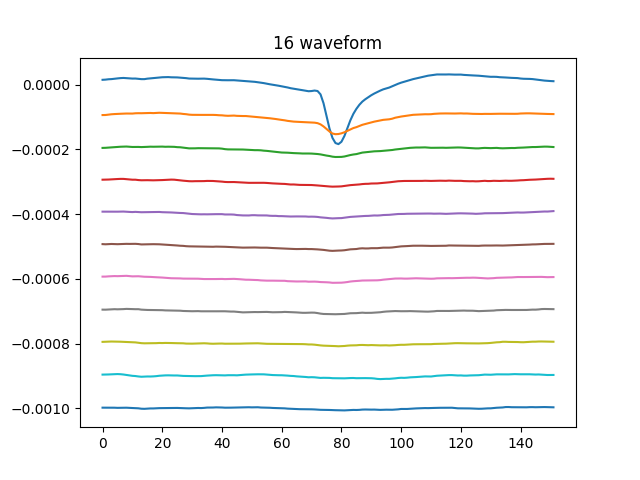

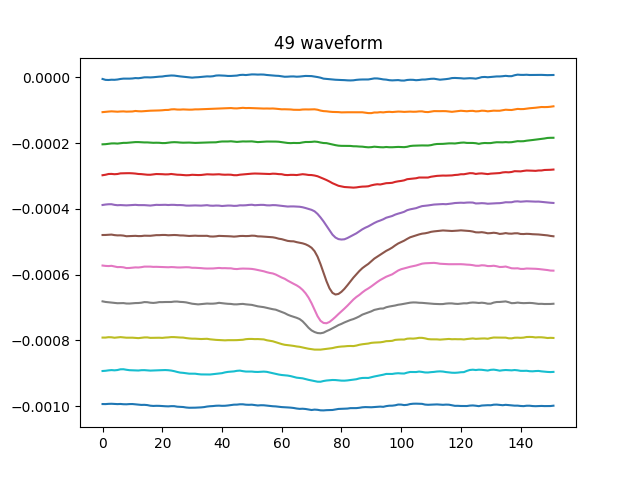

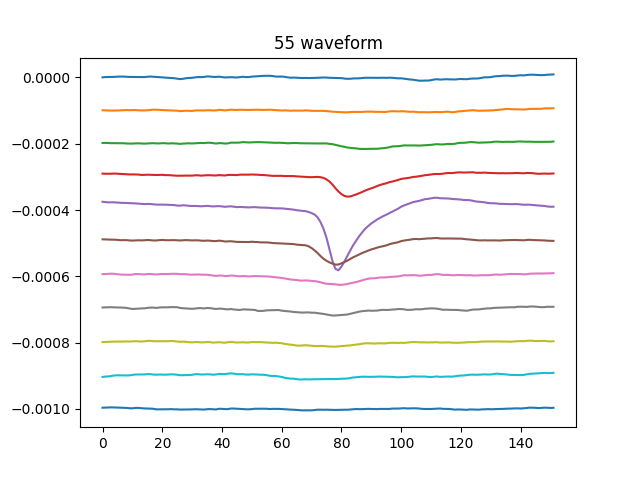

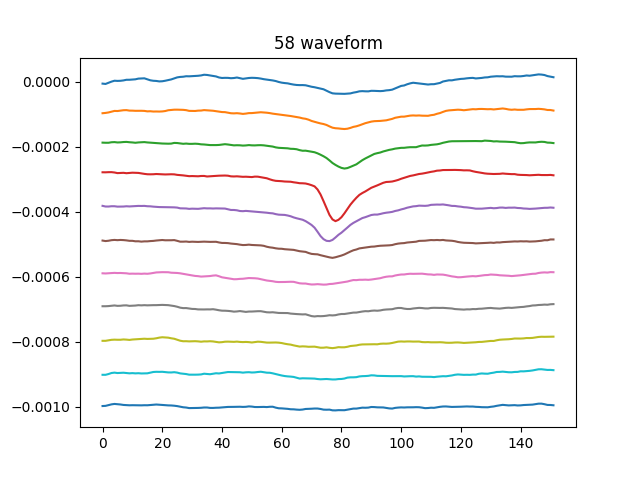

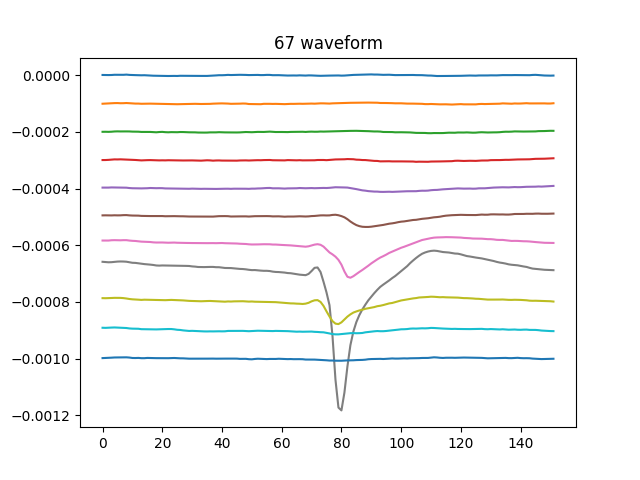

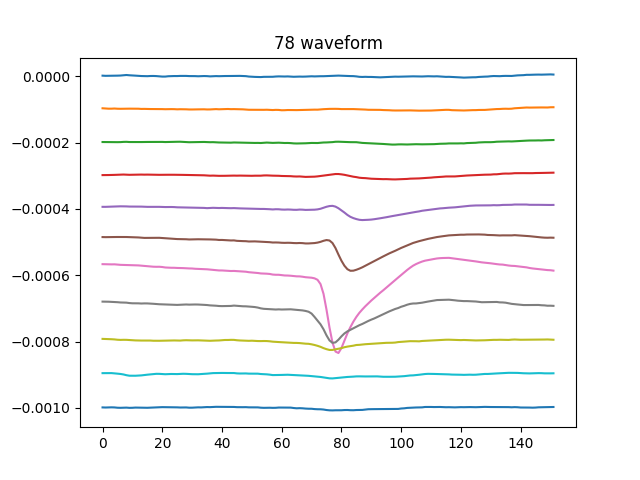

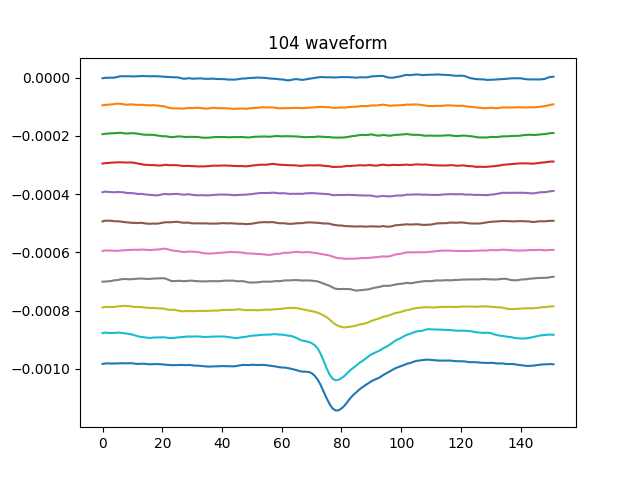

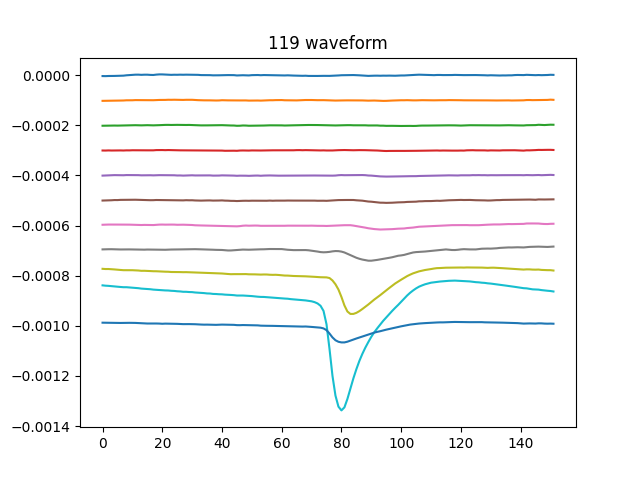

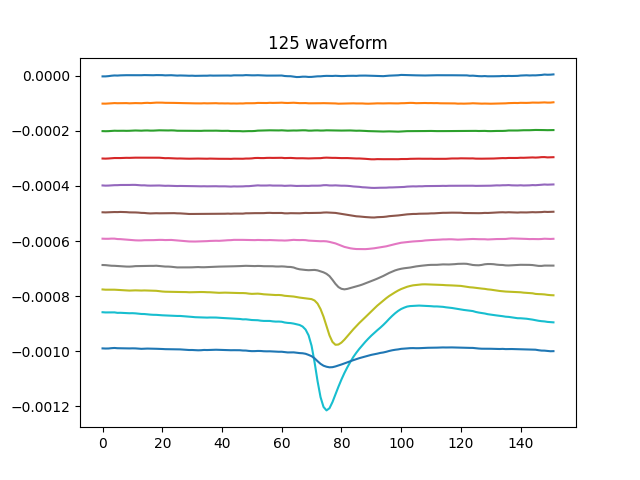

In [92]:
fig = plt.figure()
ax = plt.gca()
for ch_idx, ch_group in df_regions.groupby('Channel'):
    plt.sca(ax)
    ms = 2
    if (ch_idx==119):
        ms = 5
    plt.plot(*(tv[ch_group.index.values, :].T), '.', ms=ms, label=ch_idx, alpha=0.5)
    
    plt.figure()
    plt.plot(extra_samples_detrend[ch_group.index.values].mean(0).T - np.arange(11)*1e-4)
    plt.title(f'{ch_idx} waveform')
    
plt.sca(ax)
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.title('Spike clustering')
    
plt.legend()
display(fig)